In [1]:
import os
import numpy as np
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter

In [2]:
tf.test.is_gpu_available()

2022-02-14 14:14:14.469016: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-14 14:14:14.512240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 14:14:14.613736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 14:14:14.614458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

True

In [3]:
TrianImage="../input/chest-xray-pneumonia/chest_xray/train/" #/content/input/COVID-19/Train
TestImage="../input/chest-xray-pneumonia/chest_xray/test/"   #../input/chest-xray-pneumonia/  ../input/chest-xray-pneumonia/
ValImage="../input/chest-xray-pneumonia/chest_xray/val/"
Normalimages = os.listdir(TrianImage + "/NORMAL")
Pneumonaimages = os.listdir(TrianImage + "/PNEUMONIA") #../input/chest-xray-pneumonia/

In [4]:
print(len(Normalimages), len(Pneumonaimages))
NUM_TRAINING_IMAGES = len(Normalimages) + len(Pneumonaimages)
print(NUM_TRAINING_IMAGES)

1341 3875
5216


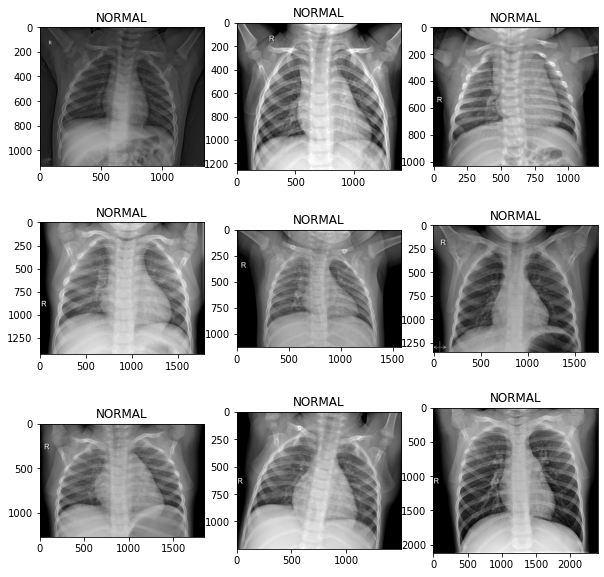

In [5]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/NORMAL",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")
plt.show()

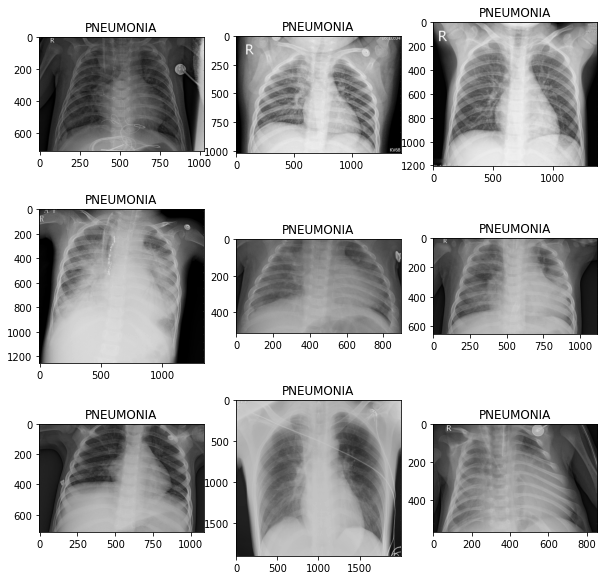

In [6]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/PNEUMONIA",Pneumonaimages[i])),cmap='gray')
    plt.title("PNEUMONIA")
plt.show()

In [7]:
filepath = [] #list of paths of images of train & validation
categories = [] #label

In [8]:
#Load the images path and label of the training set
filenames = os.listdir(os.path.join(TrianImage,'NORMAL'))
for filename in filenames:
        filepath.append(os.path.join(TrianImage,'NORMAL',filename))
        categories.append("NORMAL") #0: Normal

filenames = os.listdir(os.path.join(TrianImage,'PNEUMONIA'))
for filename in filenames:
        filepath.append(os.path.join(TrianImage,'PNEUMONIA',filename))
        categories.append("PNEUMONIA") #1: Pneumonia

In [9]:
#Load the images path and label of the validation set
filenames = os.listdir(os.path.join(ValImage,'NORMAL'))
for filename in filenames:
        filepath.append(os.path.join(ValImage,'NORMAL',filename))
        categories.append("NORMAL") #0: Normal
        
filenames = os.listdir(os.path.join(ValImage,'PNEUMONIA'))
for filename in filenames:
        filepath.append(os.path.join(ValImage,'PNEUMONIA',filename))
        categories.append("PNEUMONIA") #1: Pneumonia

Df Train-Vali:                                              filepath   label
0  ../input/chest-xray-pneumonia/chest_xray/train...  NORMAL
1  ../input/chest-xray-pneumonia/chest_xray/train...  NORMAL
2  ../input/chest-xray-pneumonia/chest_xray/train...  NORMAL
3  ../input/chest-xray-pneumonia/chest_xray/train...  NORMAL
4  ../input/chest-xray-pneumonia/chest_xray/train...  NORMAL

PNEUMONIA    3883
NORMAL       1349
Name: label, dtype: int64


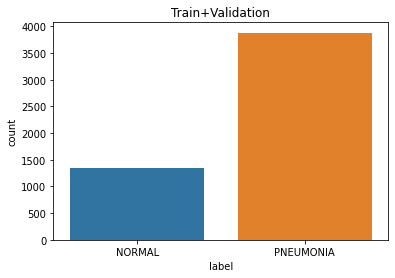

In [10]:
#Let's create a dataframe containing all images of tRAING and validation set. It's composed by 3875 imageslabelled as "Pneumonia" and 
#1341 images labelled as "Normal".
import pandas as pd
import seaborn as sns
df = pd.DataFrame({'filepath':filepath,'label':categories})
df.info
plot = sns.countplot(x ='label', data = df).set_title('Train+Validation')
print("Df Train-Vali: ",df.head())
print("")
print(df['label'].value_counts())

In [11]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

!pip install visualkeras #https://github.com/paulgavrikov/visualkeras
import visualkeras

try: #Part of original notebook to set TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

     |████████████████████████████████| 992 kB 918 kB/s            
Number of replicas: 1
2.6.2


In [12]:
train, vali = train_test_split(df, test_size=0.15,stratify=df['label'],random_state=6) #stratify to keep distribution

Train 85%: 
PNEUMONIA    3300
NORMAL       1147
Name: label, dtype: int64


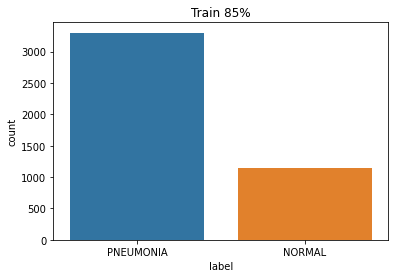

In [13]:
plot_train = sns.countplot(x ='label', data = train).set_title('Train 85%')
print('Train 85%: ')
print(train['label'].value_counts())

Validation 15%: 
PNEUMONIA    583
NORMAL       202
Name: label, dtype: int64


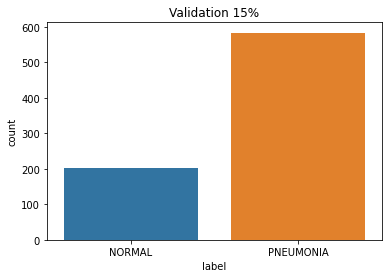

In [14]:
plot_vali = sns.countplot(x ='label', data = vali).set_title('Validation 15%')
print('Validation 15%: ')
print(vali['label'].value_counts())

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32 * strategy.num_replicas_in_sync #GPU:1 num_replicas
IMAGE_SIZE = [224, 224]
EPOCHS = 50 #early stops in model.fit-->need to save best weights

In [16]:
load = ImageDataGenerator() #To load images

#Load images [0 255] and resize images

train_set = load.flow_from_dataframe(train,
                                        x_col = 'filepath',
                                        y_col = 'label',
                                        target_size = IMAGE_SIZE,
                                        batch_size = BATCH_SIZE,
                                        class_mode = 'binary')

vali_set = load.flow_from_dataframe(vali,
                                        x_col = 'filepath',
                                        y_col = 'label',
                                        target_size = IMAGE_SIZE,
                                        batch_size = BATCH_SIZE,
                                        class_mode = 'binary')

test_set = load.flow_from_directory(TestImage,
                                        target_size = IMAGE_SIZE,
                                        batch_size = BATCH_SIZE,
                                        shuffle = False, #for confusionMatrix
                                        class_mode = 'binary')

#Check classes in output
print("train: ",train_set.class_indices)
print("vali: ",vali_set.class_indices)
print("test: ",test_set.class_indices)
#it returns a DataFrameIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size)

Found 4447 validated image filenames belonging to 2 classes.
Found 785 validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.
train:  {'NORMAL': 0, 'PNEUMONIA': 1}
vali:  {'NORMAL': 0, 'PNEUMONIA': 1}
test:  {'NORMAL': 0, 'PNEUMONIA': 1}


In [17]:
VAL_IMG_COUNT = vali_set.samples
TEST_IMG_COUNT = test_set.samples

In [18]:
print('Train: ',Counter(train_set.classes))
print('Validation: ',Counter(vali_set.classes))
print('Test: ',Counter(test_set.classes))

Train:  Counter({1: 3300, 0: 1147})
Validation:  Counter({1: 583, 0: 202})
Test:  Counter({1: 390, 0: 234})


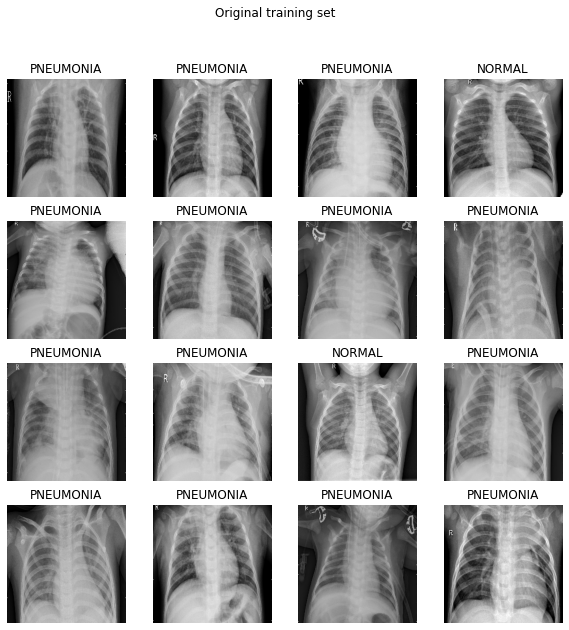

In [19]:
plt.figure(figsize=(10,10))
plt.suptitle('Original training set')
for n in range(16):
    ax = plt.subplot(4,4,n+1)
    plt.imshow(train_set[0][0][n].astype(np.uint8))  #uint8 to plot
    if train_set[0][1][n]:
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
    plt.axis("off")

In [20]:
#Data augmentation only on the training set
augment_gen = ImageDataGenerator(zoom_range = 0.2,
                                   rotation_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   ) #to perform augmentation on training set

In [21]:
aug_train_set =  augment_gen.flow_from_dataframe(train,
                                        x_col = 'filepath',
                                        y_col = 'label',
                                        target_size = IMAGE_SIZE,
                                        batch_size = BATCH_SIZE,
                                        class_mode = 'binary')
print("\n Aug_train: ",train_set.class_indices)

Found 4447 validated image filenames belonging to 2 classes.

 Aug_train:  {'NORMAL': 0, 'PNEUMONIA': 1}


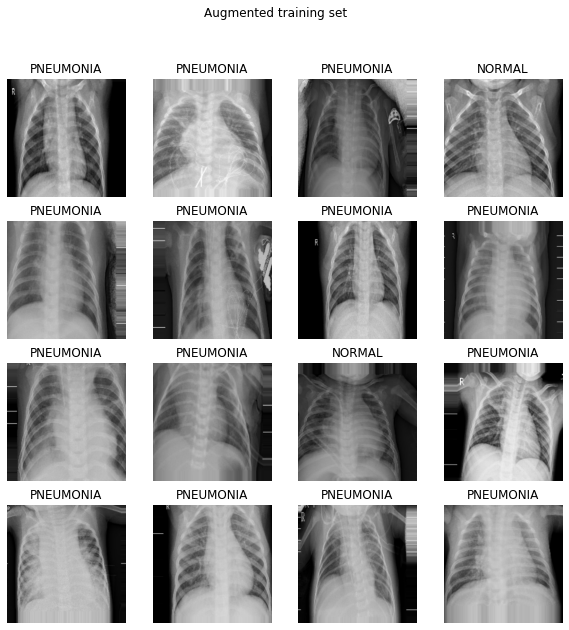

In [22]:
# images after data augmentation
plt.figure(figsize=(10,10))
plt.suptitle('Augmented training set')
for n in range(16):
    ax = plt.subplot(4,4,n+1)
    plt.imshow(aug_train_set[0][0][n].astype(np.uint8))
    if train_set[0][1][n]:
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
    plt.axis("off")

Aug_train_set
NORMAL :  1147
PNEUMONIA :  3300


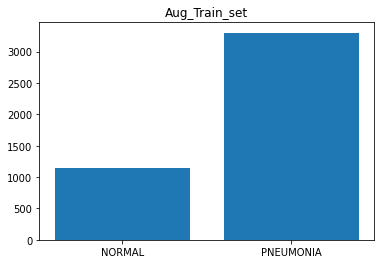

In [23]:
#class imbalance in the training
counter = Counter(aug_train_set.classes)
#print(counter.items()) #0: Normal, 1: Pneumonia

counter['NORMAL'] = counter.pop(0)
counter['PNEUMONIA'] = counter.pop(1) #change name for visualization dictionary

print('Aug_train_set')
for i in counter:
    print(i,': ',counter[i])

plt.bar(counter.keys(),counter.values())
plt.title('Aug_Train_set')
plt.show()

In [24]:
#correct data imbalancing
COUNT_PNEUMONIA=counter['PNEUMONIA']
COUNT_NORMAL=counter['NORMAL']
TRAIN_IMG_COUNT=aug_train_set.samples

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
#image labelled as Normal will be weighted more to balance the data

Weight for class 0: 1.94
Weight for class 1: 0.67


In [25]:
keras.backend.clear_session() #clear any model

In [26]:
def conv_block(filters):## convolution blockkk
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block
def dense_block(units, dropout_rate):   ## dense blockk
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [27]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Rescaling(scale=1./255), #Scaling images between [0 1]
        
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(128),
        conv_block(256),
        
        conv_block(512),
        tf.keras.layers.Dropout(0.2), 
        
        conv_block(1024),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(2048, 0.7),
        dense_block(512, 0.5),
        dense_block(256, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid') 
    ])

    return model

In [28]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
model.summary()

2022-02-14 14:23:58.896060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 14:23:58.896936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 14:23:58.897555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 14:23:58.898581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 14:23:58.899221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
sequential (Sequential)      (None, 56, 56, 128)       27072     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 256)       103296    
_________________________________________________________________
sequential_2 (Sequential)    (None, 14, 14, 512)      

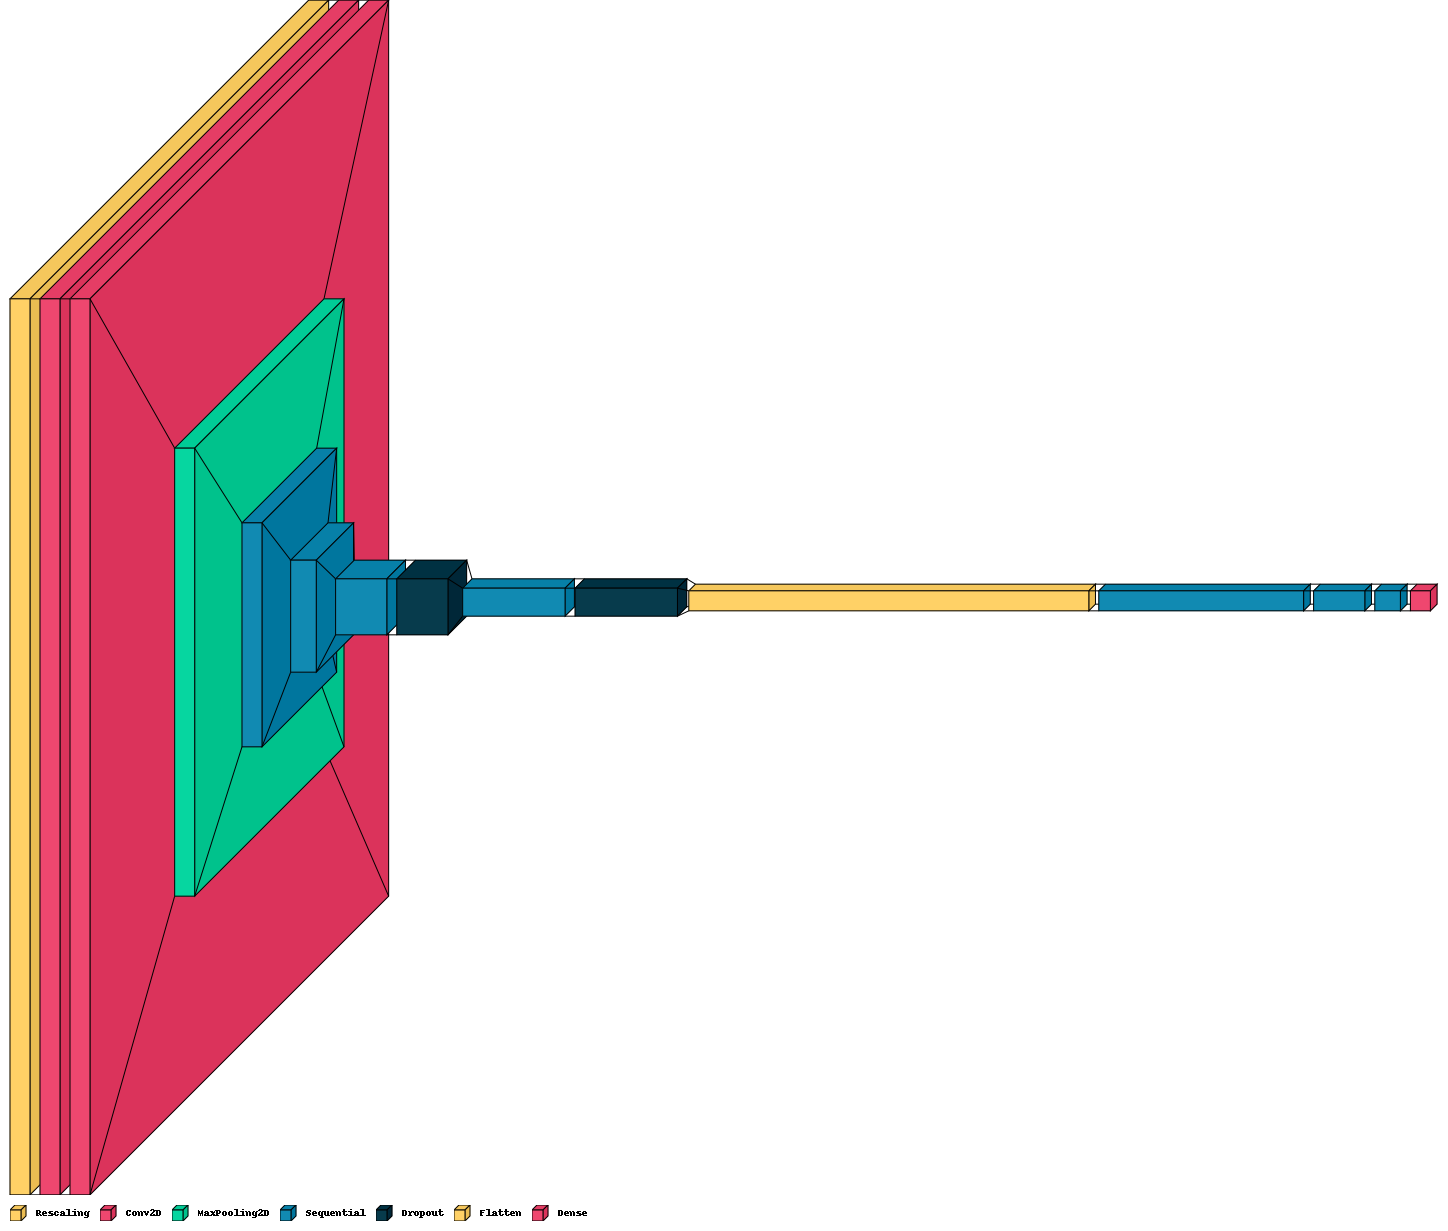

In [29]:
visualkeras.layered_view(model, legend=True)

In [30]:
print("steps_per_epoch : ",TRAIN_IMG_COUNT // BATCH_SIZE)
print("validation_steps : ",VAL_IMG_COUNT // BATCH_SIZE)

steps_per_epoch :  138
validation_steps :  24


In [31]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("CNN_xray_model.h5",
                                                    save_best_only=True,verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1)#check val_loss

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001,verbose=1) #if val_loss not improved for patience_epochs-->reduce the learning rate

In [32]:
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, 
                             classification_report, f1_score, average_precision_score, precision_recall_fscore_support)

In [33]:
history = model.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb,early_stopping_cb,reduce_lr]
)
y_pred_prob_lr = model.predict(test_set)
y_pred_prob_lr = y_pred_prob_lr > 0.5
fpr_lr, tpr_lr, thresholds_lr = roc_curve(test_set.labels, y_pred_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
precision_lr, recall_lr, th_lr = precision_recall_curve(test_set.labels, y_pred_prob_lr)

2022-02-14 14:25:39.227615: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-02-14 14:25:42.948161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


138/138 [==============================] - 144s 970ms/step - loss: 0.6184 - accuracy: 0.6915 - precision: 0.8858 - recall: 0.6704 - val_loss: 0.6576 - val_accuracy: 0.7409 - val_precision: 0.7409 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 0.65758, saving model to CNN_xray_model.h5
Epoch 2/50
138/138 [==============================] - 110s 793ms/step - loss: 0.3269 - accuracy: 0.8546 - precision: 0.9554 - recall: 0.8434 - val_loss: 0.9050 - val_accuracy: 0.7435 - val_precision: 0.7435 - val_recall: 1.0000

Epoch 00002: val_loss did not improve from 0.65758
Epoch 3/50
138/138 [==============================] - 108s 779ms/step - loss: 0.2497 - accuracy: 0.8997 - precision: 0.9676 - recall: 0.8946 - val_loss: 1.1444 - val_accuracy: 0.7435 - val_precision: 0.7435 - val_recall: 1.0000

Epoch 00003: val_loss did not improve from 0.65758
Epoch 4/50
138/138 [==============================] - 107s 778ms/step - loss: 0.2456 - accuracy: 0.9055 - precision: 0.9688 - recall: 0.

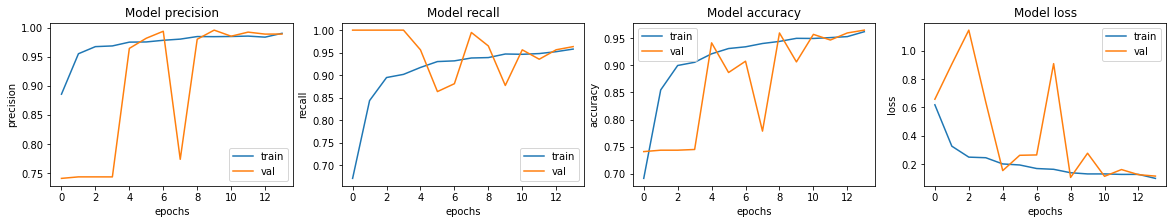

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

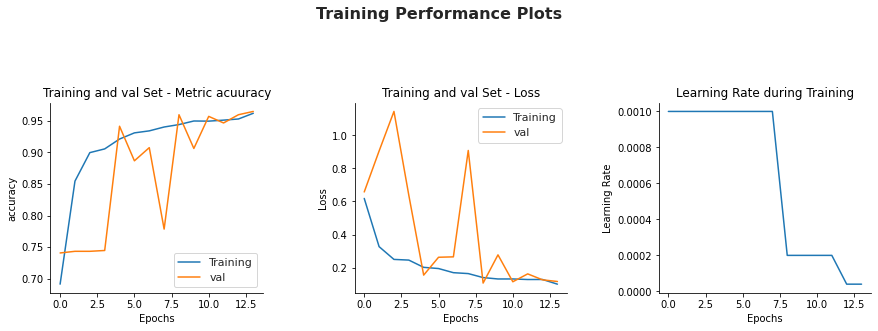

In [35]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(13,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="val");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="val");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and val Set - Metric acuuracy")
axarr[1].set_title("Training and val Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [36]:
loss, acc, prec, rec = model.evaluate(test_set)

20/20 [==============================] - 7s 303ms/step - loss: 0.3411 - accuracy: 0.8654 - precision: 0.8297 - recall: 0.9872


In [37]:
#Predicted labels
predictions = model.predict(test_set)
predictions = predictions > 0.5

#True labels
orig = test_set.labels

In [38]:
cm = confusion_matrix(orig, predictions)
print('Confusion matrix:')
print(cm)
print('')

cr = classification_report(orig, predictions)
print('Classification report:')
print(cr)
print('')

Confusion matrix:
[[155  79]
 [  5 385]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.66      0.79       234
           1       0.83      0.99      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.87      0.86       624




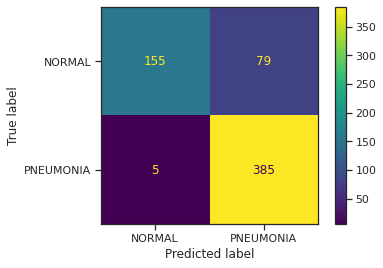

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['NORMAL','PNEUMONIA'])
disp.plot()

**Overall Results**
Accuracy Result: 86.54%
Precision Result: 89.92%
Recall Result: 82.48%
F-Score Result: 84.42%


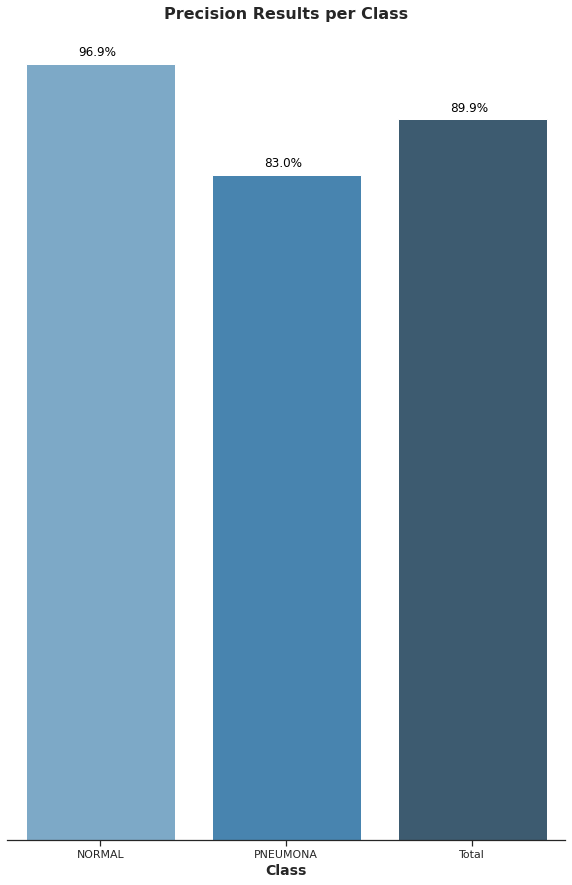

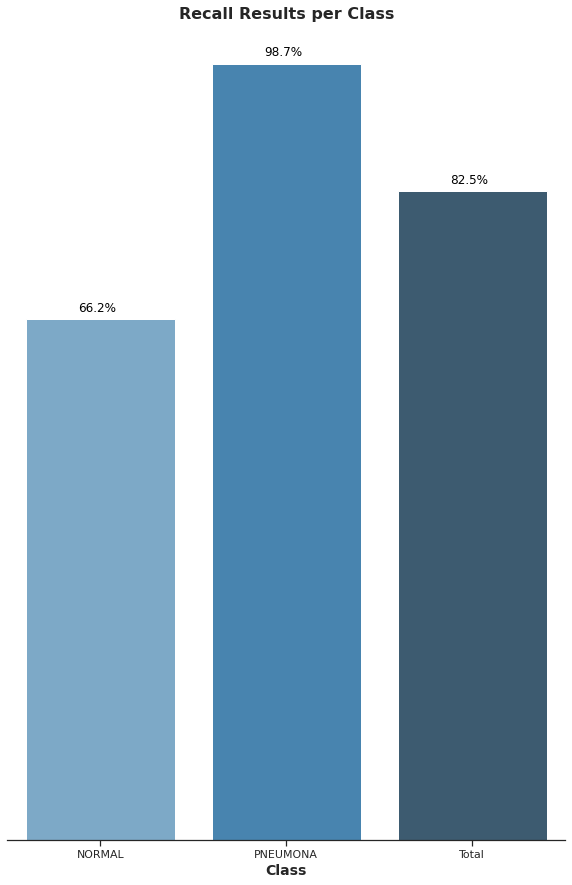

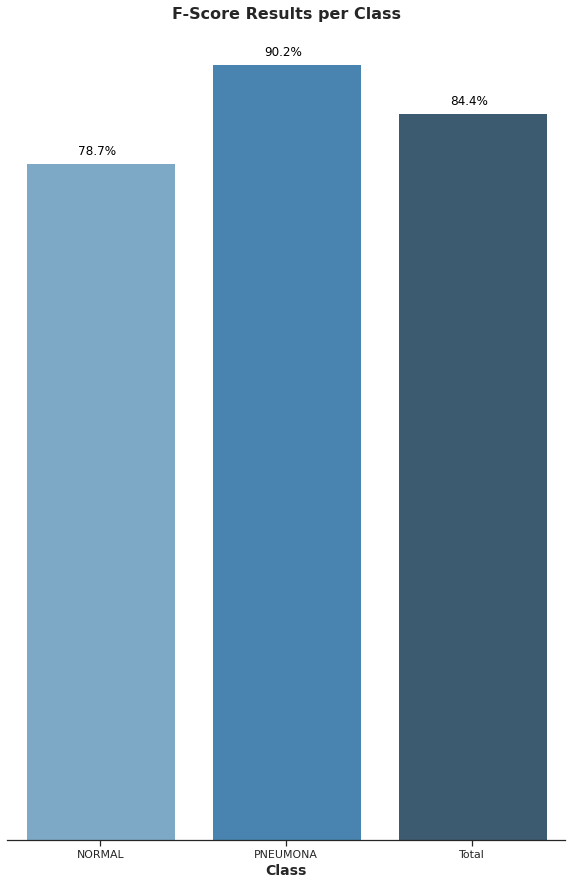

In [41]:
from sklearn.metrics import accuracy_score
#Accuracy Result
acc = accuracy_score(test_set.labels, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(test_set.labels, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(test_set.labels, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['NORMAL', 'PNEUMONA','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(10,15))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))#F-Score of the whole Dataset

errors:  84


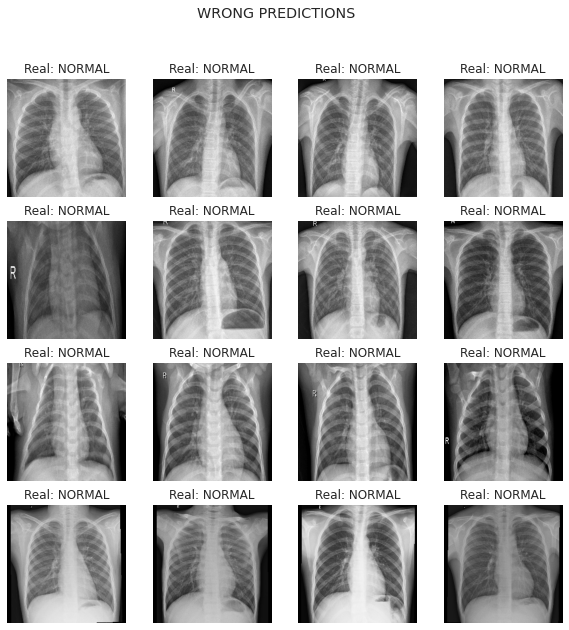

In [42]:
err=[i for i, (x, y) in enumerate(zip(predictions, orig)) if x != y] #check where orig and predictions don't match (wrong classification)
#print(err)
print('errors: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): #plot max 16 wrong predictions
    bn=err[n]//BATCH_SIZE #number of batch of wrong prediction train_set[bn][0][image]
    ib=err[n]-BATCH_SIZE*bn #number of the image in the batch size train_set[bn][0][ib]
    #print('id_err:',err[n],' batch:',bn,' diff:',err[n]-BATCH_SIZE*bn)
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8))  #uint8 to plot
    
    if test_set[bn][1][ib]: #real value
        plt.title("Real: PNEUMONIA")
    else:
        plt.title("Real: NORMAL")
    plt.axis("off")

In [43]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [44]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap  IMAGE_SIZE[0], IMAGE_SIZE[1]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((IMAGE_SIZE[0], IMAGE_SIZE[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [45]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [46]:
!pip install efficientnet
import efficientnet.tfkeras as efn

     |████████████████████████████████| 50 kB 732 kB/s            


In [47]:
# Data preprocessing
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2
#Model
import keras
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.layers.normalization import BatchNormalization
from keras.layers.normalization import batch_normalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.metrics import PrecisionAtRecall,Recall 
#Model Analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from numpy.random import seed
seed(0)
import tensorflow
tensorflow.random.set_seed(0)

In [48]:
keras.backend.clear_session() #delete the previous model (clear model variable)

In [49]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False)  # Do not include the ImageNet classifier at the top

58900480/58889256 [==============================] - 0s 0us/step


In [50]:
base_model.trainable = False #freeze the base model

In [51]:
inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

#Preprocess for VGG16
x = tf.keras.applications.vgg16.preprocess_input(inputs)

# We make sure that the base_model is running in inference mode here, passing `training=False`
x = base_model(x, training=False) #-->not updating weights of this part of the model

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D(name="GlobalAveragePooling2D_head_vgg")(x)

x = tf.keras.layers.Dense(512, activation='relu', name="dense_head_vgg")(x)
x = tf.keras.layers.Dropout(0.2, name="dropout_head_vgg")(x)  # Regularize with dropout

# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name="predictions_head_vgg")(x)
model_VGG16 = tf.keras.Model(inputs, outputs)

model_VGG16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
GlobalAveragePooling2D_head_ (None, 512)               0         
_________________________________________________________________
dense_head_vgg (Dense)       (None, 512)               262656    
_________________________________________________________________
dropout_head_vgg (Dropout)   (None, 512)               0     

In [52]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1) #check val_loss

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-5 ,verbose=1) #min_lr as input for fine tuning next

In [53]:
model_VGG16.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = model_VGG16.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)

Epoch 1/50
138/138 [==============================] - 100s 701ms/step - loss: 0.4045 - accuracy: 0.8840 - val_loss: 0.4047 - val_accuracy: 0.8997
Epoch 2/50
138/138 [==============================] - 97s 701ms/step - loss: 0.1700 - accuracy: 0.9409 - val_loss: 0.2439 - val_accuracy: 0.9297
Epoch 3/50
138/138 [==============================] - 96s 697ms/step - loss: 0.1427 - accuracy: 0.9450 - val_loss: 0.2683 - val_accuracy: 0.9206
Epoch 4/50
138/138 [==============================] - 97s 705ms/step - loss: 0.1459 - accuracy: 0.9438 - val_loss: 0.2244 - val_accuracy: 0.9258
Epoch 5/50
138/138 [==============================] - 98s 712ms/step - loss: 0.1227 - accuracy: 0.9558 - val_loss: 0.5778 - val_accuracy: 0.8268
Epoch 6/50
138/138 [==============================] - 99s 717ms/step - loss: 0.1112 - accuracy: 0.9608 - val_loss: 0.2951 - val_accuracy: 0.9193
Epoch 7/50
138/138 [==============================] - 96s 699ms/step - loss: 0.1139 - accuracy: 0.9590 - val_loss: 0.2157 - val_a

In [56]:
last_conv_layer_name = "conv5_block16_concatination"
classifier_layer_names = [
    "bn",
    "relu",
    "GlobalAveragePooling2D_head_vgg",  #GlobalAveragePooling2D_head_vgg
    "dense_head_vgg",
    "dropout_head_vgg",     #predictions_head_vgg
    "predictions_head_vgg"
]

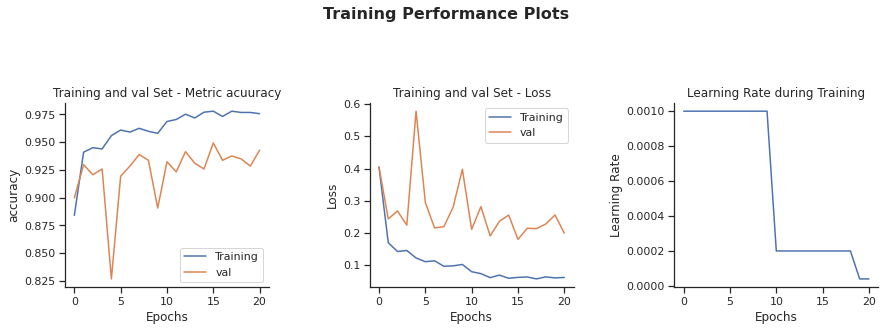

In [57]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(13,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="val");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="val");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and val Set - Metric acuuracy")
axarr[1].set_title("Training and val Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [58]:
# Unfreeze the base model
base_model.trainable = True

model_VGG16.summary()

model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(1e-5), #Very low learning rate
              loss='binary_crossentropy',
              metrics='accuracy')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
GlobalAveragePooling2D_head_ (None, 512)               0         
_________________________________________________________________
dense_head_vgg (Dense)       (None, 512)               262656    
_________________________________________________________________
dropout_head_vgg (Dropout)   (None, 512)               0     

In [59]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("VGG16_xray_model.h5",
                                                    save_best_only=True,verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1) 

In [60]:
history = model_VGG16.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)
#y_pred = model_MobileNet.predict(test_set)
y_pred_prob_VGG16 = model_VGG16.predict(test_set)
y_pred_prob_VGG16 = y_pred_prob_VGG16 > 0.5
fpr_VGG16, tpr_VGG16, thresholds_VGG16 = roc_curve(test_set.labels, y_pred_prob_VGG16)
roc_auc_VGG16 = auc(fpr_VGG16, tpr_VGG16)
precision_VGG16, recall_VGG16, th_VGG16 = precision_recall_curve(test_set.labels, y_pred_prob_VGG16)

Epoch 1/50
138/138 [==============================] - 101s 723ms/step - loss: 0.0888 - accuracy: 0.9635 - val_loss: 0.4395 - val_accuracy: 0.8828
Epoch 2/50
138/138 [==============================] - 101s 733ms/step - loss: 0.0678 - accuracy: 0.9733 - val_loss: 0.2508 - val_accuracy: 0.9323
Epoch 3/50
138/138 [==============================] - 101s 729ms/step - loss: 0.0480 - accuracy: 0.9812 - val_loss: 0.3322 - val_accuracy: 0.9258
Epoch 4/50
138/138 [==============================] - 101s 729ms/step - loss: 0.0415 - accuracy: 0.9832 - val_loss: 0.1803 - val_accuracy: 0.9674
Epoch 5/50
138/138 [==============================] - 101s 730ms/step - loss: 0.0445 - accuracy: 0.9828 - val_loss: 0.3686 - val_accuracy: 0.9023
Epoch 6/50
138/138 [==============================] - 99s 718ms/step - loss: 0.0314 - accuracy: 0.9891 - val_loss: 0.4096 - val_accuracy: 0.8971
Epoch 7/50
138/138 [==============================] - 102s 741ms/step - loss: 0.0316 - accuracy: 0.9891 - val_loss: 0.2546 - 

In [61]:
model_VGG16.save("model_VGG16.h5")

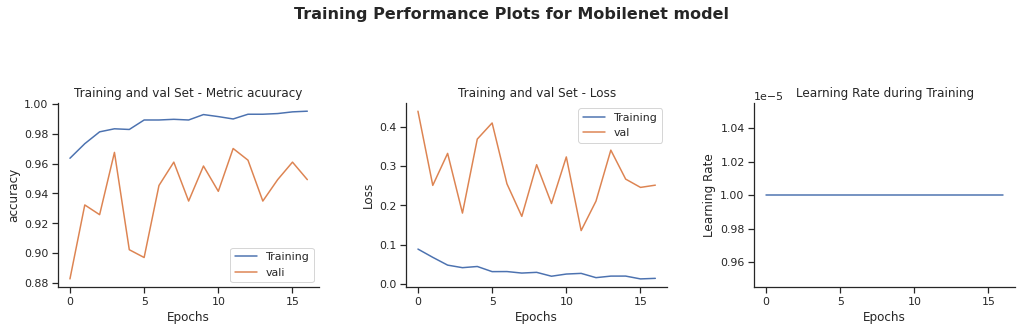

In [62]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="vali");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="val");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and val Set - Metric acuuracy")
axarr[1].set_title("Training and val Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots for Mobilenet model',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [63]:
loss, acc = model_VGG16.evaluate(test_set)

20/20 [==============================] - 6s 271ms/step - loss: 0.4068 - accuracy: 0.9295


In [64]:
#Predicted labels
prediction_VGG16 = model_VGG16.predict(test_set)
prediction_VGG16 = prediction_VGG16 > 0.5

#True labels
orig_VGG16 = test_set.labels

In [65]:
cm_VGG16 = confusion_matrix(orig_VGG16, y_pred_prob_VGG16)
print('Confusion matrix:')
print(cm_VGG16)
print('')

cr_VGG16 = classification_report(orig_VGG16, y_pred_prob_VGG16)
print('Classification report:')
print(cr_VGG16)
print('')

Confusion matrix:
[[195  39]
 [  5 385]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       234
           1       0.91      0.99      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624




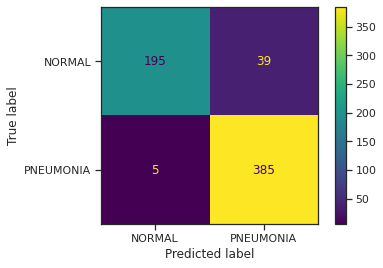

In [66]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_VGG16,display_labels=['NORMAL','PNEUMONIA'])
disp.plot()

errori commessi:  44


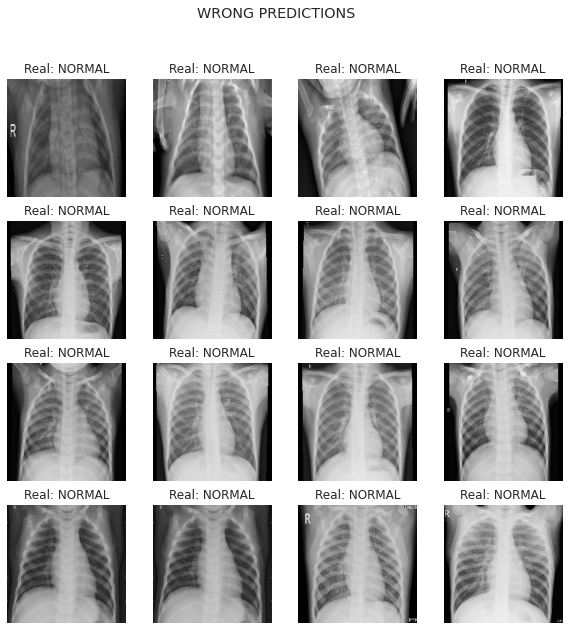

In [67]:
err=[i for i, (x, y) in enumerate(zip(y_pred_prob_VGG16, test_set.labels)) if x != y] #check where orig and predictions don't match (wrong classification)
#print(err)
print('errori commessi: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): #plot max 16 wrong predictions
    bn=err[n]//BATCH_SIZE #number of batch of wrong prediction train_set[bn][0][image]
    ib=err[n]-BATCH_SIZE*bn #number of the image in the batch size train_set[bn][0][ib]
    #print('id_err:',err[n],' batch:',bn,' diff:',err[n]-BATCH_SIZE*bn)
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8))  #uint8 to plot
    
    if test_set[bn][1][ib]: #real value
        plt.title("Real: PNEUMONIA")
    else:
        plt.title("Real: NORMAL")
    plt.axis("off")

**Overall Results**
Accuracy Result: 92.95%
Precision Result: 94.15%
Recall Result: 91.03%
F-Score Result: 92.23%


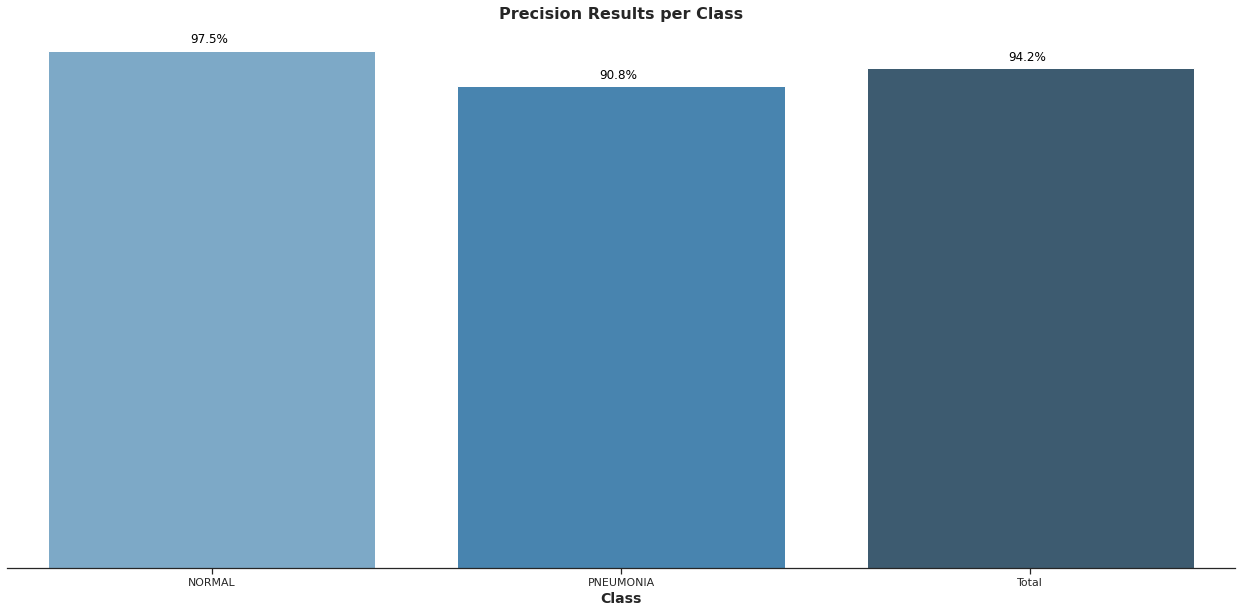

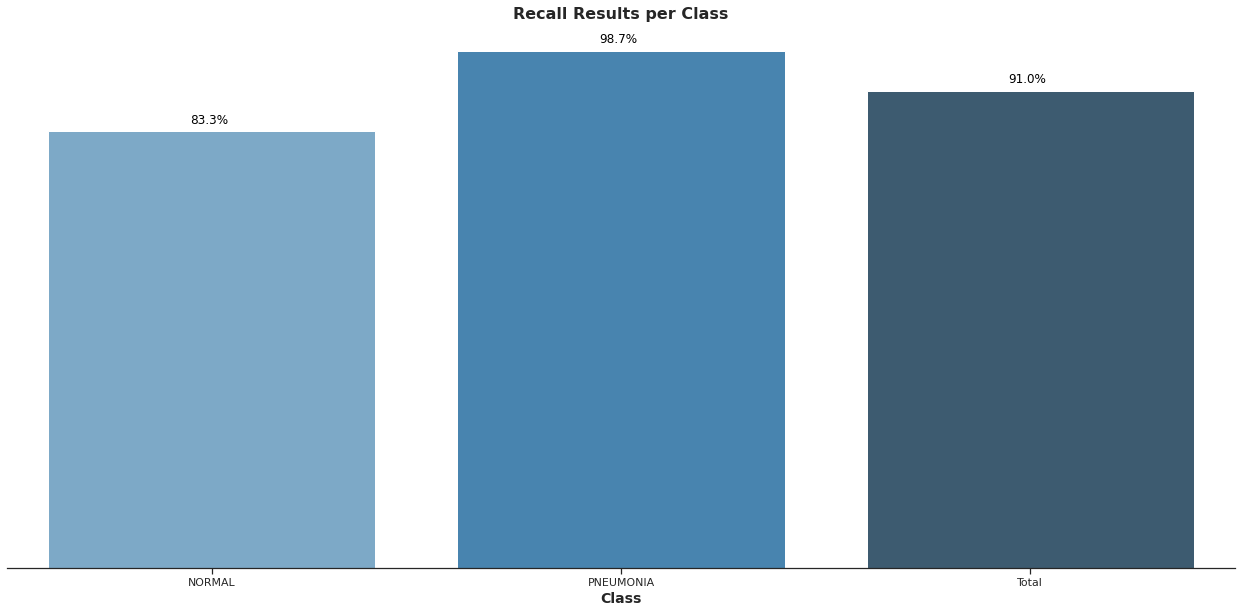

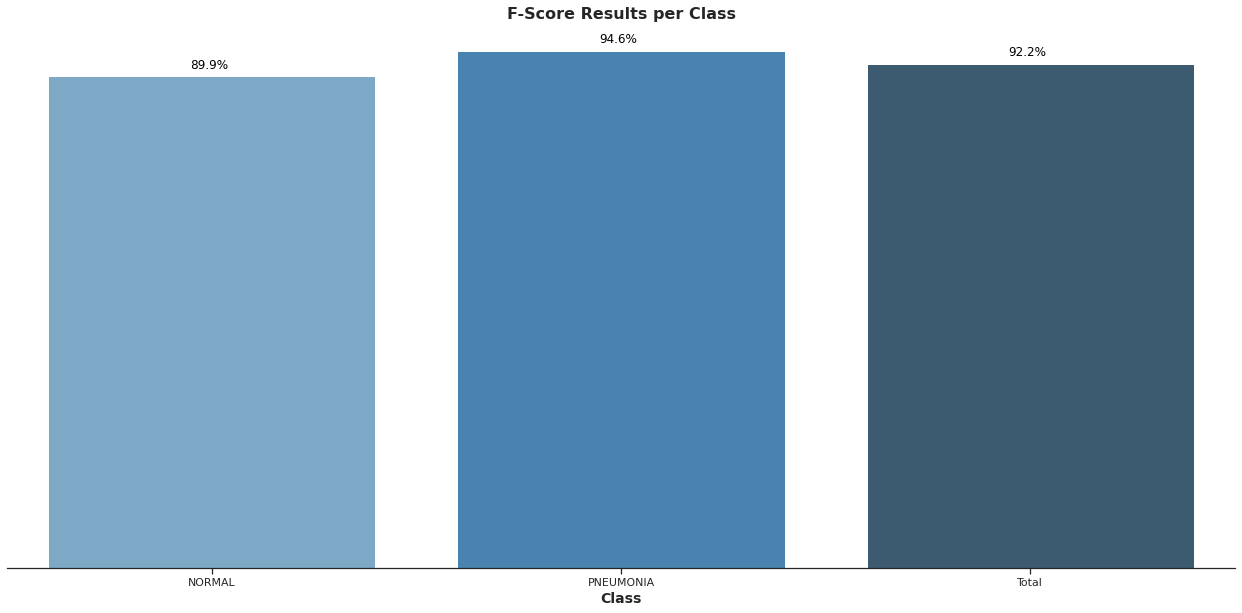

In [68]:
#Accuracy Result
acc = accuracy_score(test_set.labels, y_pred_prob_VGG16)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(test_set.labels, y_pred_prob_VGG16, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(test_set.labels, y_pred_prob_VGG16, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['NORMAL', 'PNEUMONIA', 'Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))#F-Score of the whole Dataset

In [69]:
keras.backend.clear_session()

In [70]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False)  # Do not include the ImageNet classifier at the top

83697664/83683744 [==============================] - 0s 0us/step


In [71]:
base_model.trainable = False #freeze the base model

In [72]:
inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

#Preprocess for Xception
x = tf.keras.applications.xception.preprocess_input(inputs)

# We make sure that the base_model is running in inference mode here passing `training=False`  Xception
x = base_model(x, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D(name="GlobalAveragePooling2D_head_xception")(x)

x = tf.keras.layers.Dense(256, activation="relu", name="dense_head_xception")(x)
x = tf.keras.layers.Dropout(0.2, name="dropout_head_xception")(x)  # Regularize with dropout

# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="predictions_head_xception")(x)
model_Xception = tf.keras.Model(inputs, outputs)

model_Xception.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
GlobalAveragePooling2D_head_ (None, 2048)              0         
_________________________________________________________________
dense_head_xception (Dense)  (None, 256)               524544    
_________________________________________________________________
dropout_head_xception (Dropo (None, 256)               0     

In [73]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1)#check val_loss

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-5 ,verbose=1) #min_lr as input for fine tuning next

In [74]:
model_Xception.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = model_Xception.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)

Epoch 1/50
138/138 [==============================] - 97s 689ms/step - loss: 0.2350 - accuracy: 0.9035 - val_loss: 0.1712 - val_accuracy: 0.9349
Epoch 2/50
138/138 [==============================] - 95s 690ms/step - loss: 0.1776 - accuracy: 0.9259 - val_loss: 0.2209 - val_accuracy: 0.9128
Epoch 3/50
138/138 [==============================] - 100s 723ms/step - loss: 0.1562 - accuracy: 0.9375 - val_loss: 0.3569 - val_accuracy: 0.8490
Epoch 4/50
138/138 [==============================] - 96s 697ms/step - loss: 0.1393 - accuracy: 0.9429 - val_loss: 0.2000 - val_accuracy: 0.9206
Epoch 6/50
138/138 [==============================] - 95s 687ms/step - loss: 0.1611 - accuracy: 0.9318 - val_loss: 0.2706 - val_accuracy: 0.8880
Epoch 7/50
138/138 [==============================] - 97s 703ms/step - loss: 0.1317 - accuracy: 0.9486 - val_loss: 0.1738 - val_accuracy: 0.9349

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 8/50
138/138 [===========================

In [75]:
last_conv_layer_name = "conv5_xception_concatination"
classifier_layer_names = [
    "bn",
    "relu",
    "GlobalAveragePooling2D_head_xception",  #GlobalAveragePooling2D_head_vgg
    "dense_head_xception",
    "dropout_head_xception",     #predictions_head_vgg
    "predictions_head_xception"
]

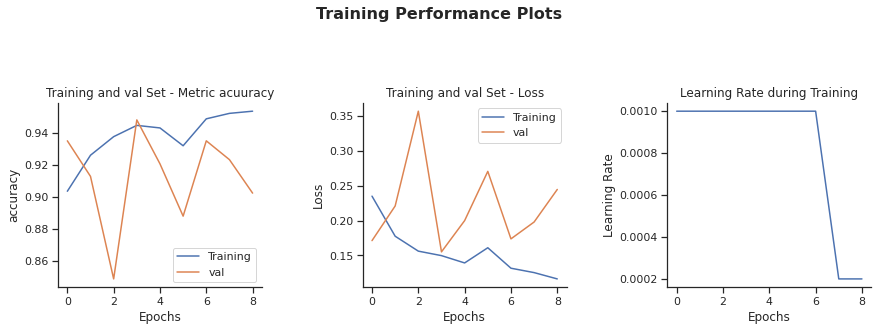

In [76]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(13,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="val");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="val");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and val Set - Metric acuuracy")
axarr[1].set_title("Training and val Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [77]:
# Unfreeze the base model
base_model.trainable = True

model_Xception.summary()

model_Xception.compile(optimizer=tf.keras.optimizers.Adam(1e-5), #Very low learning rate
              loss='binary_crossentropy',
              metrics='accuracy')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
GlobalAveragePooling2D_head_ (None, 2048)              0         
_________________________________________________________________
dense_head_xception (Dense)  (None, 256)               524544    
_________________________________________________________________
dropout_head_xception (Dropo (None, 256)               0     

In [78]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Xception_xray_model.h5",
                                                    save_best_only=True,verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1) #check val_loss

In [79]:
history = model_Xception.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)
#y_pred = model_MobileNet.predict(test_set)
y_pred_prob_Xception = model_Xception.predict(test_set)
y_pred_prob_Xception = y_pred_prob_Xception > 0.5
fpr_Xception, tpr_Xception, thresholds_Xception = roc_curve(test_set.labels, y_pred_prob_Xception)
roc_auc_Xception = auc(fpr_Xception, tpr_Xception)
precision_Xception, recall_Xception, th_Xception = precision_recall_curve(test_set.labels, y_pred_prob_Xception)

Epoch 1/50
138/138 [==============================] - 121s 842ms/step - loss: 0.1136 - accuracy: 0.9536 - val_loss: 0.1815 - val_accuracy: 0.9453
Epoch 2/50
138/138 [==============================] - 114s 827ms/step - loss: 0.0838 - accuracy: 0.9651 - val_loss: 0.1722 - val_accuracy: 0.9414
Epoch 3/50
138/138 [==============================] - 115s 829ms/step - loss: 0.0753 - accuracy: 0.9710 - val_loss: 0.1155 - val_accuracy: 0.9635
Epoch 4/50
138/138 [==============================] - 114s 822ms/step - loss: 0.0520 - accuracy: 0.9801 - val_loss: 0.2140 - val_accuracy: 0.9323
Epoch 5/50
138/138 [==============================] - 115s 830ms/step - loss: 0.0483 - accuracy: 0.9812 - val_loss: 0.1557 - val_accuracy: 0.9505
Epoch 6/50
138/138 [==============================] - 115s 835ms/step - loss: 0.0442 - accuracy: 0.9826 - val_loss: 0.3113 - val_accuracy: 0.8971
Epoch 7/50
138/138 [==============================] - 114s 823ms/step - loss: 0.0333 - accuracy: 0.9878 - val_loss: 0.2593 -

In [80]:
model_Xception.save("model_Xception.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


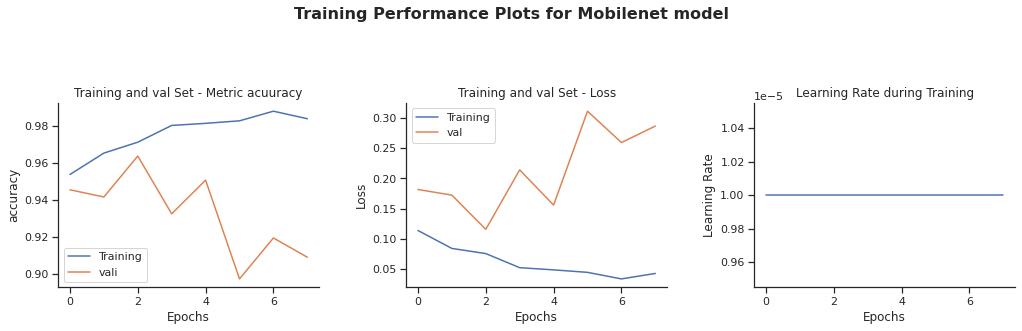

In [81]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="vali");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="val");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and val Set - Metric acuuracy")
axarr[1].set_title("Training and val Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots for Mobilenet model',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [82]:
loss, acc = model_Xception.evaluate(test_set)

20/20 [==============================] - 6s 282ms/step - loss: 0.3334 - accuracy: 0.9022


In [83]:
#Predicted labels
prediction_Xception = model_Xception.predict(test_set)
prediction_Xception = prediction_Xception > 0.5

#True labels
orig_Xception = test_set.labels

In [84]:
cm_Xception = confusion_matrix(orig_Xception, prediction_Xception)
print('Confusion matrix:')
print(cm_Xception)
print('')

cr_Xception = classification_report(orig_Xception, prediction_Xception)
print('Classification report:')
print(cr_Xception)
print('')

Confusion matrix:
[[179  55]
 [  6 384]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       234
           1       0.87      0.98      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624




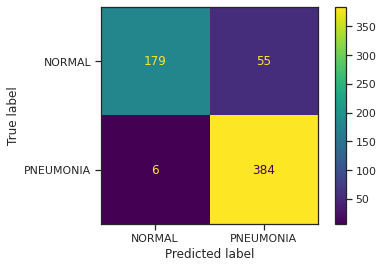

In [85]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_Xception,display_labels=['NORMAL','PNEUMONIA'])
disp.plot()

errors:  61


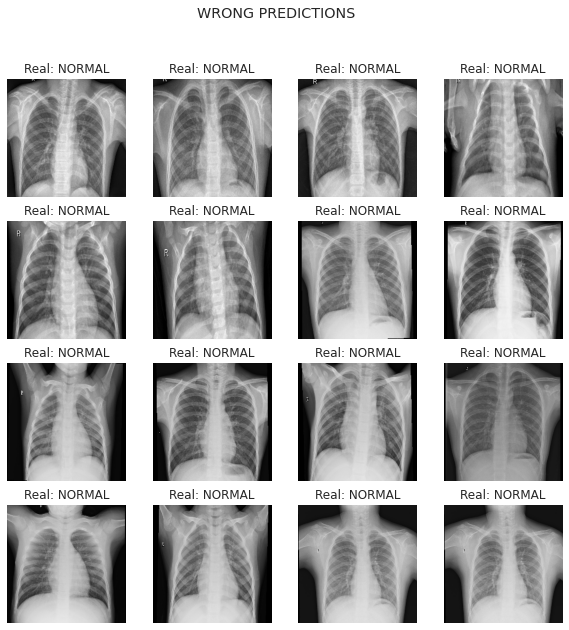

In [86]:
err=[i for i, (x, y) in enumerate(zip(y_pred_prob_Xception, test_set.labels)) if x != y] #check where orig and predictions don't match (wrong classification)
#print(err)
print('errors: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): #plot max 16 wrong predictions
    bn=err[n]//BATCH_SIZE #number of batch of wrong prediction train_set[bn][0][image]
    ib=err[n]-BATCH_SIZE*bn #number of the image in the batch size train_set[bn][0][ib]
    #print('id_err:',err[n],' batch:',bn,' diff:',err[n]-BATCH_SIZE*bn)
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8))  #uint8 to plot
    
    if test_set[bn][1][ib]: #real value
        plt.title("Real: PNEUMONIA")
    else:
        plt.title("Real: NORMAL")
    plt.axis("off")

**Overall Results**
Accuracy Result: 90.22%
Precision Result: 92.11%
Recall Result: 87.48%
F-Score Result: 89.04%


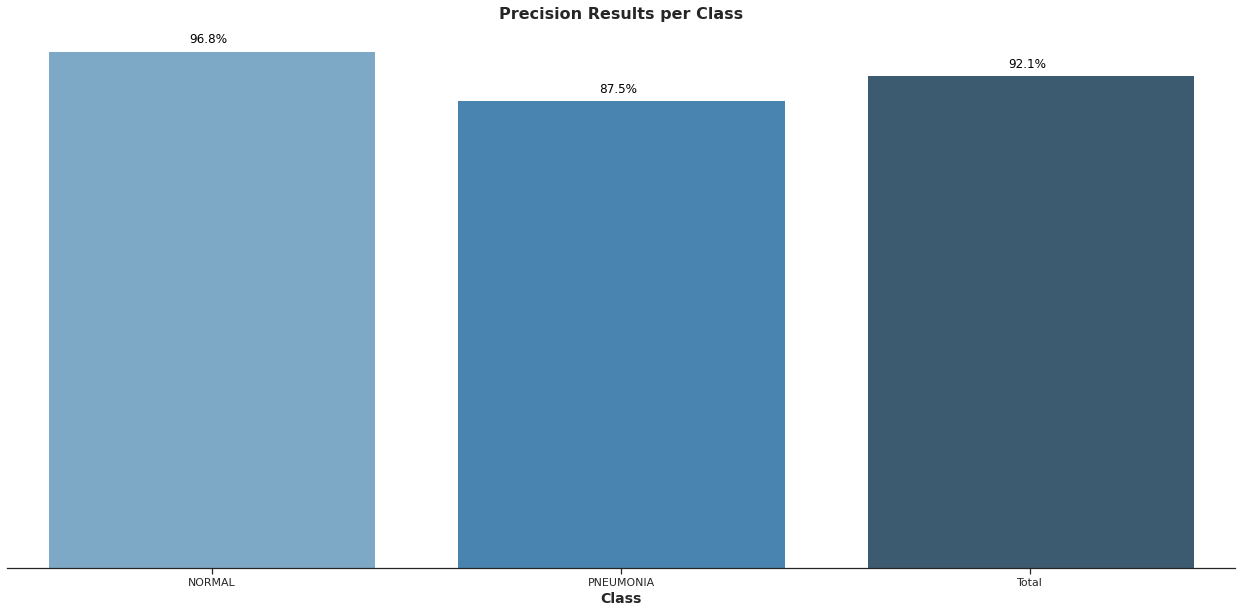

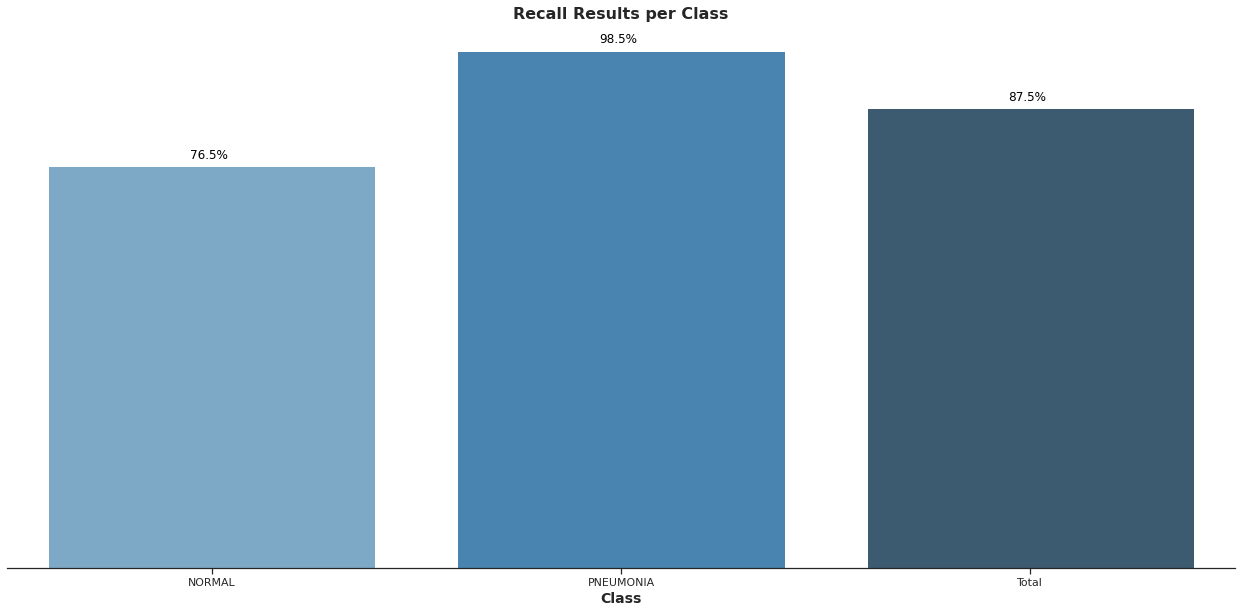

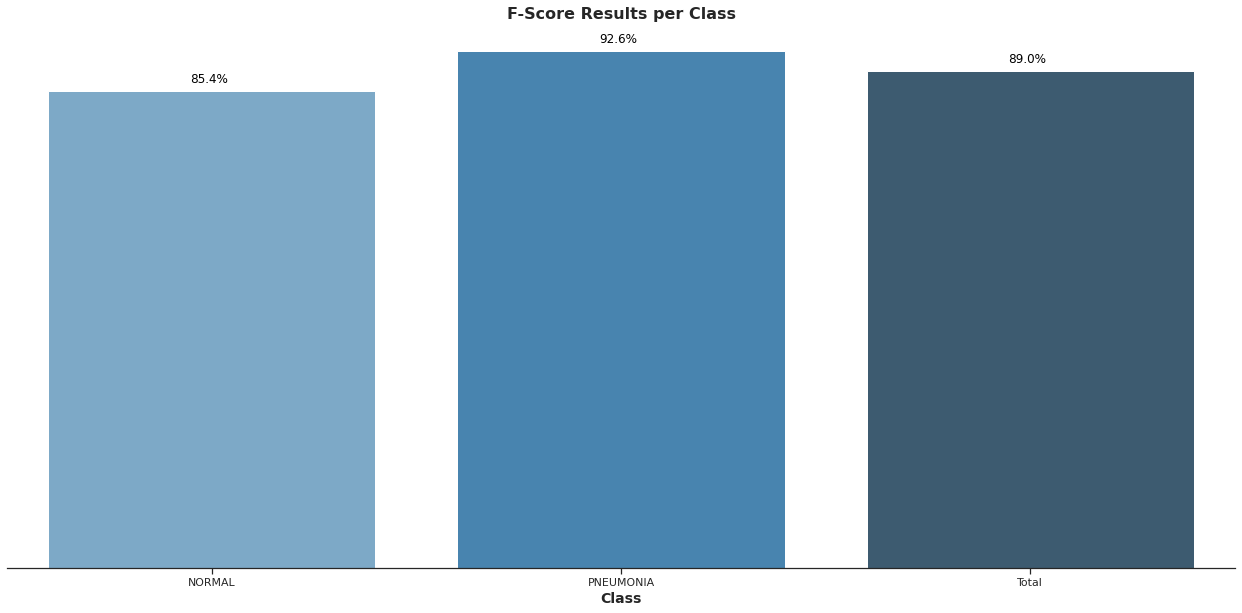

In [87]:
#Accuracy Result
acc = accuracy_score(test_set.labels, y_pred_prob_Xception)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(test_set.labels, y_pred_prob_Xception, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(test_set.labels, y_pred_prob_Xception, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['NORMAL', 'PNEUMONIA', 'Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))#F-Score of the whole Dataset

In [88]:
keras.backend.clear_session()

In [89]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False)  # Do not include the ImageNet classifier at the top

234561536/234545216 [==============================] - 1s 0us/step


In [90]:
base_model.trainable = False #freeze the base model

In [91]:
inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

#Preprocess for ResNet152V2
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)

# We make sure that the base_model is running in inference mode here, passing `training=False`
x = base_model(x, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D(name="Globalaveragepooling2d_head_resnet_v2")(x)

x = tf.keras.layers.Dense(256, activation='relu', name="dense_head_resnet_v2")(x)
x = tf.keras.layers.Dropout(0.2, name="dropout_head_resnet_v2")(x)  # Regularize with dropout

# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name="predictions_head_resnet_v2")(x)
model_ResNet152V2 = tf.keras.Model(inputs, outputs)

model_ResNet152V2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
Globalaveragepooling2d_head_ (None, 2048)              0         
_________________________________________________________________
dense_head_resnet_v2 (Dense) (None, 256)               524544    
_________________________________________________________________
dropout_head_resnet_v2 (Drop (None, 256)               0     

In [92]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1)#check val_loss

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-5 ,verbose=1) #min_lr as input for fine tuning next

In [93]:
model_ResNet152V2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = model_ResNet152V2.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)

Epoch 1/50
138/138 [==============================] - 110s 742ms/step - loss: 0.2360 - accuracy: 0.9069 - val_loss: 0.1729 - val_accuracy: 0.9349
Epoch 2/50
138/138 [==============================] - 99s 715ms/step - loss: 0.1599 - accuracy: 0.9441 - val_loss: 0.1209 - val_accuracy: 0.9557
Epoch 3/50
138/138 [==============================] - 100s 727ms/step - loss: 0.1399 - accuracy: 0.9427 - val_loss: 0.3370 - val_accuracy: 0.8659
Epoch 4/50
138/138 [==============================] - 101s 735ms/step - loss: 0.1351 - accuracy: 0.9502 - val_loss: 0.0884 - val_accuracy: 0.9701
Epoch 5/50
138/138 [==============================] - 101s 733ms/step - loss: 0.1092 - accuracy: 0.9552 - val_loss: 0.1777 - val_accuracy: 0.9310
Epoch 6/50
138/138 [==============================] - 100s 726ms/step - loss: 0.1186 - accuracy: 0.9547 - val_loss: 0.1638 - val_accuracy: 0.9375
Epoch 7/50
138/138 [==============================] - 100s 728ms/step - loss: 0.1074 - accuracy: 0.9561 - val_loss: 0.1366 - 

In [94]:
last_conv_layer_name = "top_conv"
classifier_layer_names = [
    "top_bn",
    "top_activation",
    "Globalaveragepooling2d_head_resnet_v2",
    "dense_head_resnet_v2",
    "dropout_head_resnet_v2",
    "predictions_head_resnet_v2"
]

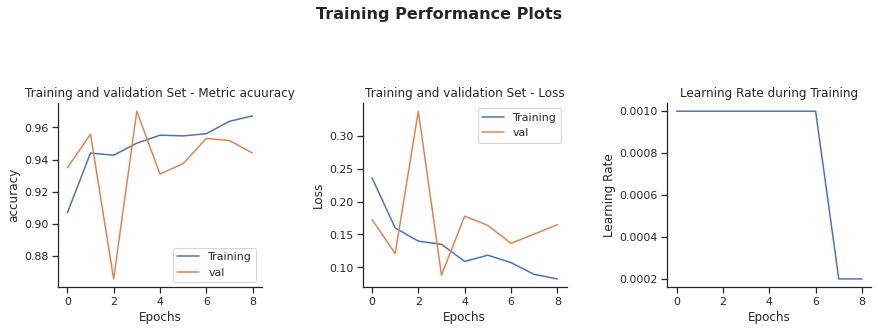

In [95]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(13,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="val");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="val");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and validation Set - Metric acuuracy")
axarr[1].set_title("Training and validation Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [96]:
# Unfreeze the base model
base_model.trainable = True

model_ResNet152V2.summary()

model_ResNet152V2.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss='binary_crossentropy',
              metrics='accuracy')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
Globalaveragepooling2d_head_ (None, 2048)              0         
_________________________________________________________________
dense_head_resnet_v2 (Dense) (None, 256)               524544    
_________________________________________________________________
dropout_head_resnet_v2 (Drop (None, 256)               0     

In [97]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ResNet152V2_xray_model.h5",
                                                    save_best_only=True,verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3,
                                                     restore_best_weights=True,verbose=1)#check val_loss

In [98]:
history = model_ResNet152V2.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)
#y_pred = model_MobileNet.predict(test_set)
y_pred_prob_ResNet152V2 = model_ResNet152V2.predict(test_set)
y_pred_prob_ResNet152V2 = y_pred_prob_ResNet152V2 > 0.5
fpr_ResNet152V2, tpr_ResNet152V2, thresholds_ResNet152V2 = roc_curve(test_set.labels, y_pred_prob_ResNet152V2)
roc_auc_ResNet152V2 = auc(fpr_ResNet152V2, tpr_ResNet152V2)
precision_ResNet152V2, recall_ResNet152V2, th_ResNet152V2 = precision_recall_curve(test_set.labels, y_pred_prob_ResNet152V2)

Epoch 1/50
138/138 [==============================] - 136s 878ms/step - loss: 0.1074 - accuracy: 0.9576 - val_loss: 0.2024 - val_accuracy: 0.9427
Epoch 2/50
138/138 [==============================] - 119s 861ms/step - loss: 0.0783 - accuracy: 0.9676 - val_loss: 0.1860 - val_accuracy: 0.9466
Epoch 3/50
138/138 [==============================] - 119s 859ms/step - loss: 0.0579 - accuracy: 0.9794 - val_loss: 0.3675 - val_accuracy: 0.8841
Epoch 4/50
138/138 [==============================] - 118s 854ms/step - loss: 0.0582 - accuracy: 0.9776 - val_loss: 0.2661 - val_accuracy: 0.9141
Epoch 5/50
138/138 [==============================] - 118s 852ms/step - loss: 0.0419 - accuracy: 0.9830 - val_loss: 0.2195 - val_accuracy: 0.9414
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


In [99]:
model_ResNet152V2.save("model_ResNet152V2.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


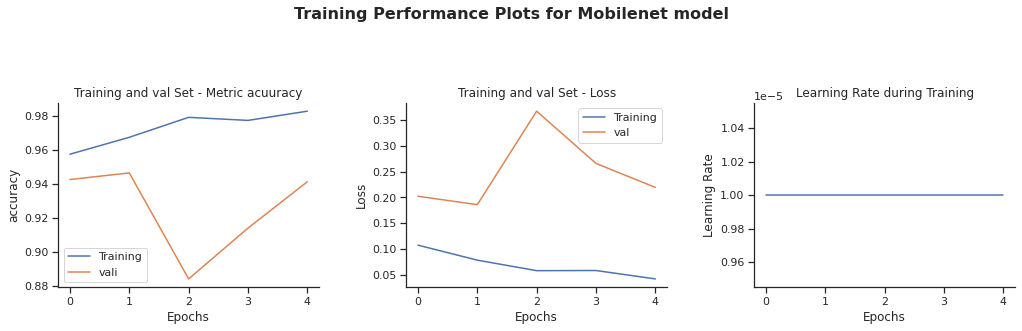

In [100]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="vali");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="val");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and val Set - Metric acuuracy")
axarr[1].set_title("Training and val Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots for Mobilenet model',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [101]:
loss, acc = model_ResNet152V2.evaluate(test_set)

20/20 [==============================] - 6s 293ms/step - loss: 0.3058 - accuracy: 0.9119


In [102]:
#Predicted labels
prediction_ResNet152V2 = model_ResNet152V2.predict(test_set)
prediction_ResNet152V2 = prediction_ResNet152V2 > 0.5

#True labels
orig_ResNet152V2 = test_set.labels

In [103]:
cm_ResNet152V2 = confusion_matrix(orig_ResNet152V2, prediction_ResNet152V2)
print('Confusion matrix:')
print(cm_ResNet152V2)
print('')

cr_ResNet152V2 = classification_report(orig_ResNet152V2, prediction_ResNet152V2)
print('Classification report:')
print(cr_ResNet152V2)
print('')

Confusion matrix:
[[192  42]
 [ 13 377]]

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87       234
           1       0.90      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624




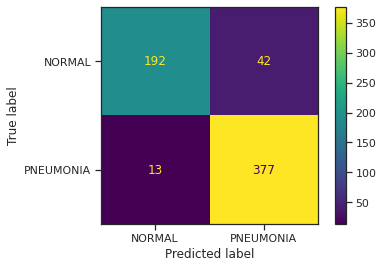

In [104]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ResNet152V2,display_labels=['NORMAL','PNEUMONIA'])
disp.plot()

errors:  55


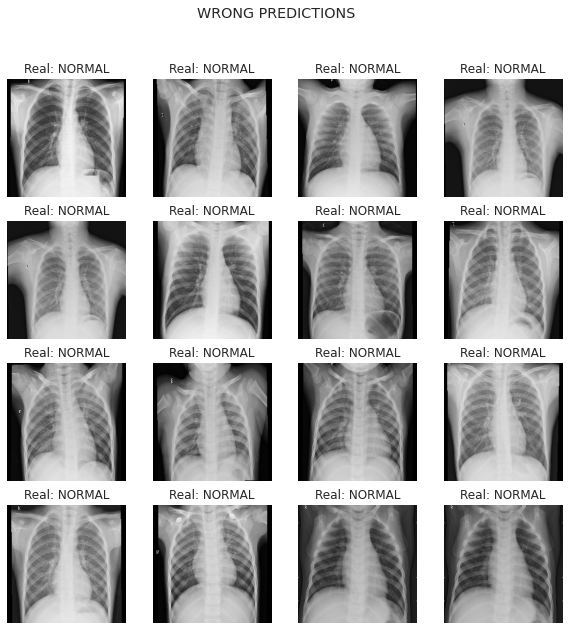

In [105]:
err=[i for i, (x, y) in enumerate(zip(y_pred_prob_ResNet152V2, test_set.labels)) if x != y] #check where orig and predictions don't match (wrong classification)
#print(err)
print('errors: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): #plot max 16 wrong predictions
    bn=err[n]//BATCH_SIZE #number of batch of wrong prediction train_set[bn][0][image]
    ib=err[n]-BATCH_SIZE*bn #number of the image in the batch size train_set[bn][0][ib]
    #print('id_err:',err[n],' batch:',bn,' diff:',err[n]-BATCH_SIZE*bn)
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8))  #uint8 to plot
    
    if test_set[bn][1][ib]: #real value
        plt.title("Real: PNEUMONIA")
    else:
        plt.title("Real: NORMAL")
    plt.axis("off")

**Overall Results**
Accuracy Result: 91.19%
Precision Result: 91.82%
Recall Result: 89.36%
F-Score Result: 90.34%


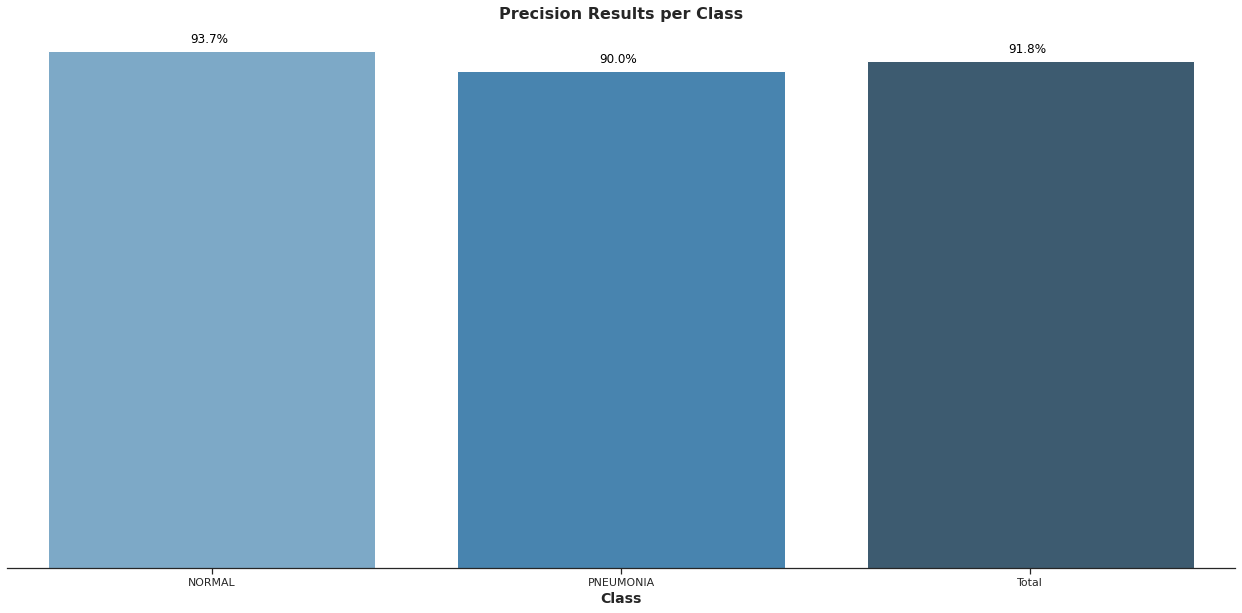

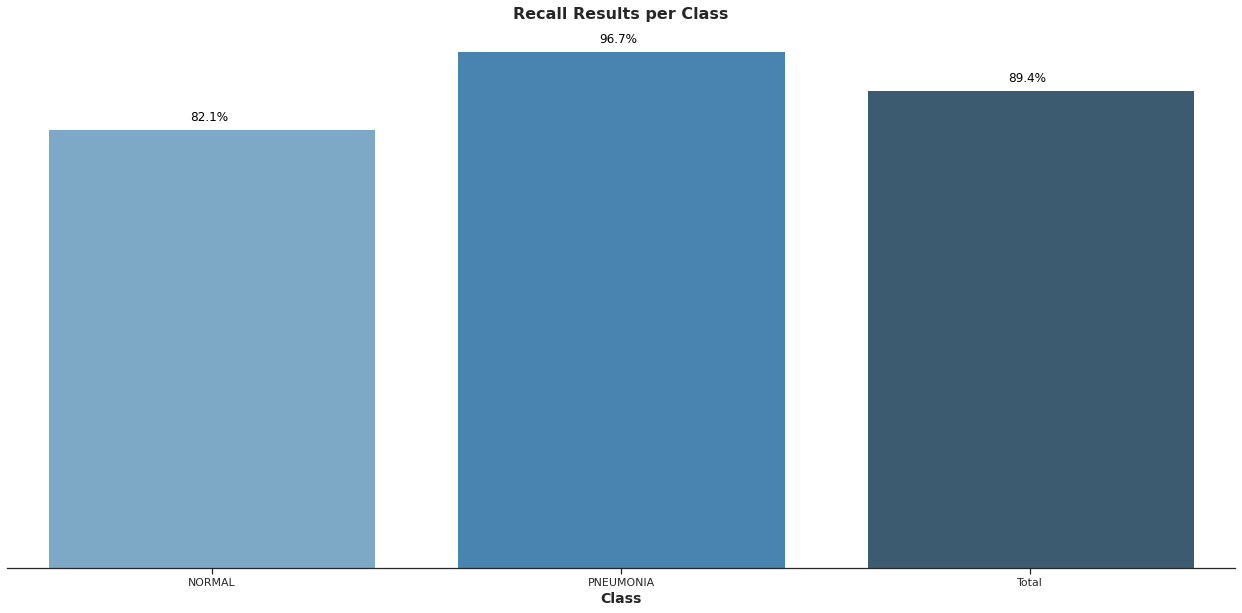

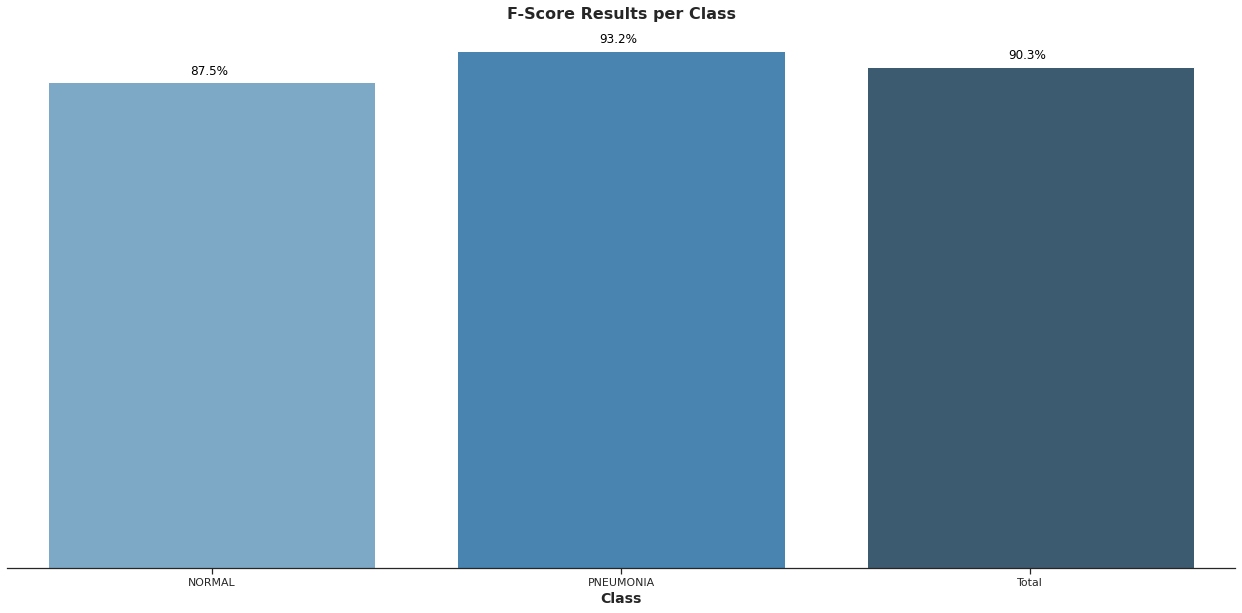

In [106]:
#Accuracy Result
acc = accuracy_score(test_set.labels, y_pred_prob_ResNet152V2)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(test_set.labels, y_pred_prob_ResNet152V2, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(test_set.labels, y_pred_prob_ResNet152V2, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['NORMAL', 'PNEUMONIA', 'Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))#F-Score of the whole Dataset

In [107]:
keras.backend.clear_session()

In [108]:
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False)  # Do not include the ImageNet classifier at the top

87924736/87910968 [==============================] - 0s 0us/step


In [109]:
base_model.trainable = False #freeze the base model

In [110]:
inputs = keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D(name="Globalaveragepooling2d_head_InceptionV3")(x)
x = keras.layers.Dense(256, activation='relu', name="dense_head_InceptionV3")(x)  #dense_head_InceptionV3
x = keras.layers.Dropout(0.2, name="dropout_head_InceptionV3")(x)
outputs = keras.layers.Dense(1, activation='sigmoid', name="predictions_head_InceptionV3")(x)
model_InceptionV3  = keras.Model(inputs, outputs)
model_InceptionV3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
Globalaveragepooling2d_head_ (None, 2048)              0         
_________________________________________________________________
dense_head_InceptionV3 (Dens (None, 256)               524544    
_________________________________________________________________
dropout_head_InceptionV3 (Dr (None, 256)               0         
_________________________________________________________________
predictions_head_InceptionV3 (None, 1)                 257       
Total params: 22,327,585
Trainable params: 524,801
Non-trainable params: 21,802,784
___________________________________________

In [111]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1) #check val_loss

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-5 ,verbose=1) #min_lr as input for fine tuning next

In [112]:
model_InceptionV3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = model_InceptionV3.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)

Epoch 1/50
138/138 [==============================] - 102s 710ms/step - loss: 4.2333 - accuracy: 0.7905 - val_loss: 0.3574 - val_accuracy: 0.8529
Epoch 2/50
138/138 [==============================] - 96s 693ms/step - loss: 0.3588 - accuracy: 0.8308 - val_loss: 0.6839 - val_accuracy: 0.6289
Epoch 3/50
138/138 [==============================] - 93s 672ms/step - loss: 0.3211 - accuracy: 0.8569 - val_loss: 0.4974 - val_accuracy: 0.7630
Epoch 4/50
138/138 [==============================] - 92s 669ms/step - loss: 0.3092 - accuracy: 0.8571 - val_loss: 0.2365 - val_accuracy: 0.9167
Epoch 5/50
138/138 [==============================] - 92s 669ms/step - loss: 0.2882 - accuracy: 0.8684 - val_loss: 0.2529 - val_accuracy: 0.8880
Epoch 6/50
138/138 [==============================] - 92s 669ms/step - loss: 0.2785 - accuracy: 0.8729 - val_loss: 0.2994 - val_accuracy: 0.8633
Epoch 7/50
138/138 [==============================] - 92s 665ms/step - loss: 0.2954 - accuracy: 0.8691 - val_loss: 0.2740 - val_a

In [113]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "Globalaveragepooling2d_head_InceptionV3",
    "dense_head_InceptionV3",
    "dropout_head_InceptionV3",
    "predictions_head_InceptionV3"
]

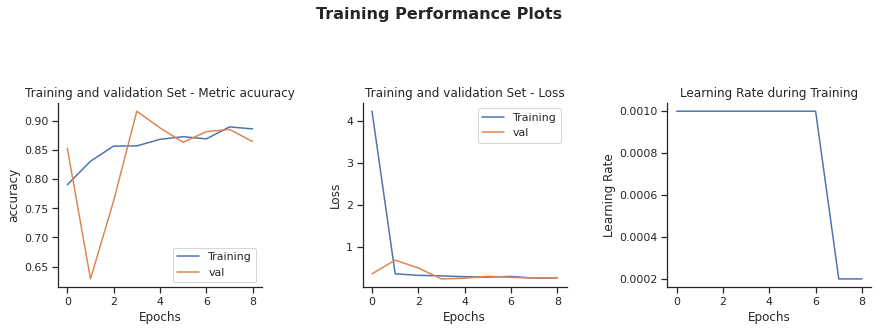

In [114]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(13,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="val");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="val");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and validation Set - Metric acuuracy")
axarr[1].set_title("Training and validation Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [115]:
# Unfreeze the base model
base_model.trainable = True

model_InceptionV3.summary()

model_InceptionV3.compile(optimizer=tf.keras.optimizers.Adam(1e-5), #Very low learning rate
              loss='binary_crossentropy',
              metrics='accuracy')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
Globalaveragepooling2d_head_ (None, 2048)              0         
_________________________________________________________________
dense_head_InceptionV3 (Dens (None, 256)               524544    
_________________________________________________________________
dropout_head_InceptionV3 (Dr (None, 256)               0         
_________________________________________________________________
predictions_head_InceptionV3 (None, 1)                 257       
Total params: 22,327,585
Trainable params: 22,293,153
Non-trainable params: 34,432
____________________________________________

In [116]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("InceptionV3_xray_model.h5",
                                                    save_best_only=True,verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1) #check val_loss by default for the early stop (check if imp

In [117]:
history = model_InceptionV3.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)
#y_pred = model_MobileNet.predict(test_set)
y_pred_prob_InceptionV3 = model_InceptionV3.predict(test_set)
y_pred_prob_InceptionV3 = y_pred_prob_InceptionV3 > 0.5
fpr_InceptionV3, tpr_InceptionV3, thresholds_InceptionV3 = roc_curve(test_set.labels, y_pred_prob_InceptionV3)
roc_auc_InceptionV3 = auc(fpr_InceptionV3, tpr_InceptionV3)
precision_InceptionV3, recall_InceptionV3, th_InceptionV3 = precision_recall_curve(test_set.labels, y_pred_prob_InceptionV3)

Epoch 1/50
138/138 [==============================] - 108s 734ms/step - loss: 0.3579 - accuracy: 0.8417 - val_loss: 0.4096 - val_accuracy: 0.7747
Epoch 2/50
138/138 [==============================] - 98s 713ms/step - loss: 0.2867 - accuracy: 0.8698 - val_loss: 0.3473 - val_accuracy: 0.8542
Epoch 3/50
138/138 [==============================] - 98s 708ms/step - loss: 0.2535 - accuracy: 0.8940 - val_loss: 0.1241 - val_accuracy: 0.9544
Epoch 4/50
138/138 [==============================] - 100s 728ms/step - loss: 0.1993 - accuracy: 0.9205 - val_loss: 0.1428 - val_accuracy: 0.9362
Epoch 5/50
138/138 [==============================] - 98s 711ms/step - loss: 0.1922 - accuracy: 0.9196 - val_loss: 0.1696 - val_accuracy: 0.9258
Epoch 6/50
138/138 [==============================] - 98s 710ms/step - loss: 0.1897 - accuracy: 0.9277 - val_loss: 0.1214 - val_accuracy: 0.9544
Epoch 7/50
138/138 [==============================] - 98s 708ms/step - loss: 0.1725 - accuracy: 0.9311 - val_loss: 0.1468 - val_

In [118]:
model_InceptionV3.save("model_InceptionV3.h5")

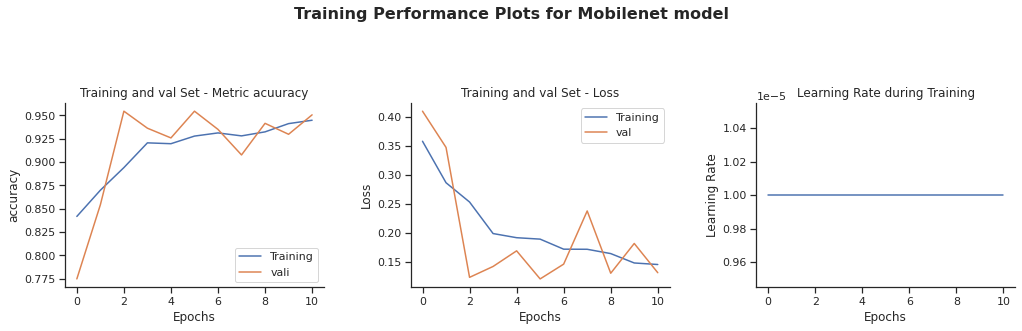

In [119]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="vali");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="val");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and val Set - Metric acuuracy")
axarr[1].set_title("Training and val Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots for Mobilenet model',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [120]:
loss, acc = model_InceptionV3.evaluate(test_set)

20/20 [==============================] - 6s 258ms/step - loss: 0.2651 - accuracy: 0.9199


In [121]:
#Predicted labels
prediction_InceptionV3 = model_InceptionV3.predict(test_set)
prediction_InceptionV3 = prediction_InceptionV3 > 0.5

#True labels
orig_InceptionV3 = test_set.labels

In [122]:
cm_InceptionV3 = confusion_matrix(orig_InceptionV3, prediction_InceptionV3)
print('Confusion matrix:')
print(cm_InceptionV3)
print('')

cr_InceptionV3 = classification_report(orig_InceptionV3, prediction_InceptionV3)
print('Classification report:')
print(cr_InceptionV3)
print('')

Confusion matrix:
[[193  41]
 [  9 381]]

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       234
           1       0.90      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624




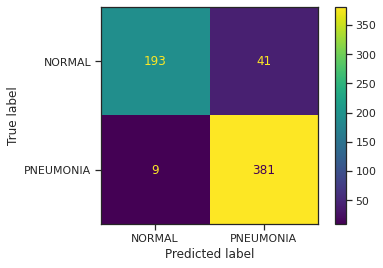

In [123]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_InceptionV3,display_labels=['NORMAL','PNEUMONIA'])
disp.plot()

errors:  50


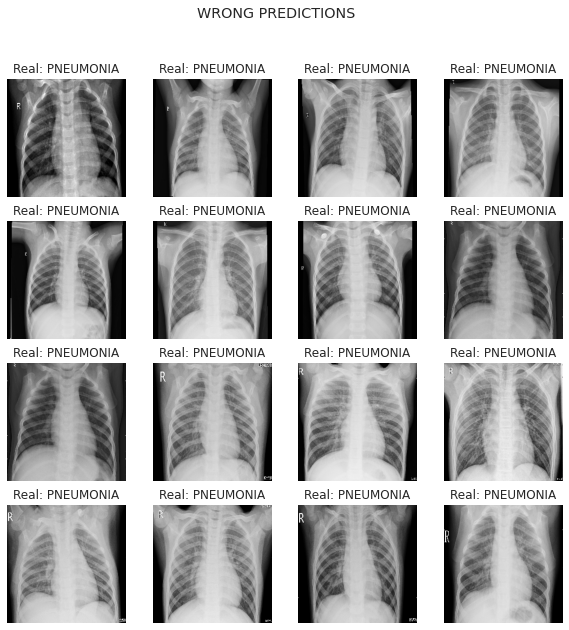

In [124]:
err=[i for i, (x, y) in enumerate(zip(y_pred_prob_InceptionV3, test_set.labels)) if x != y] #check where orig and predictions don't match (wrong classification)
#print(err)
print('errors: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): #plot max 16 wrong predictions
    bn=err[n]//BATCH_SIZE #number of batch of wrong prediction train_set[bn][0][image]
    ib=err[n]-BATCH_SIZE*bn #number of the image in the batch size train_set[bn][0][ib]
    #print('id_err:',err[n],' batch:',bn,' diff:',err[n]-BATCH_SIZE*bn)
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8))  #uint8 to plot
    
    if test_set[bn][1][ib]: #real value
        plt.title("Real: NORMAL")
    else:
        plt.title("Real: PNEUMONIA")
    plt.axis("off")

**Overall Results**
Accuracy Result: 91.99%
Precision Result: 92.91%
Recall Result: 90.09%
F-Score Result: 91.19%


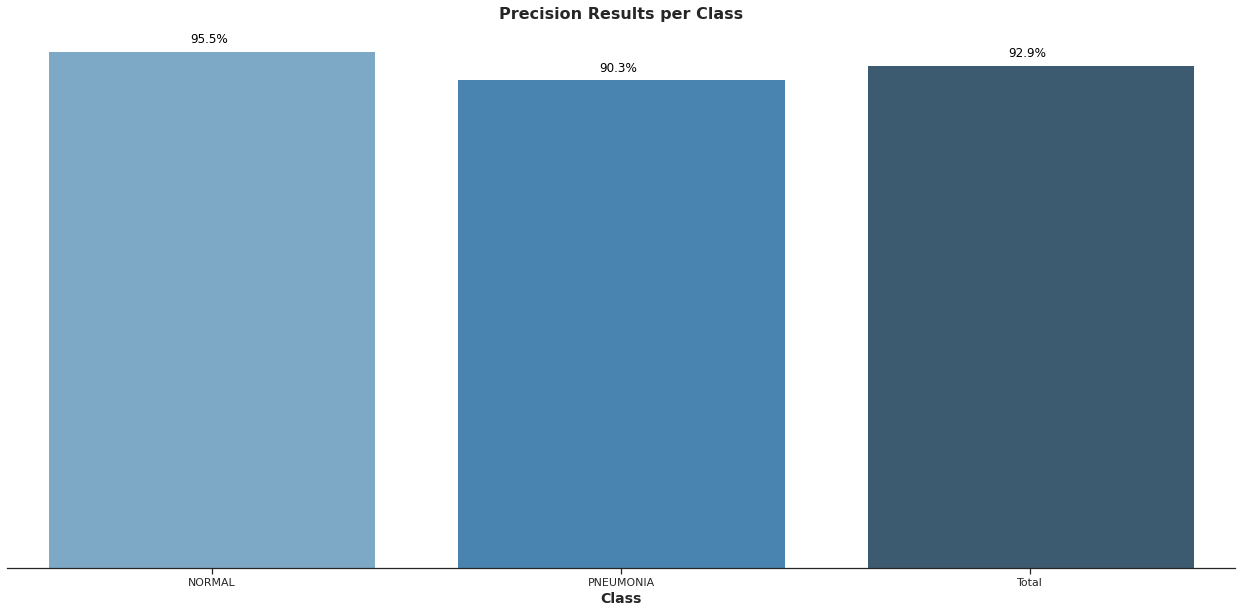

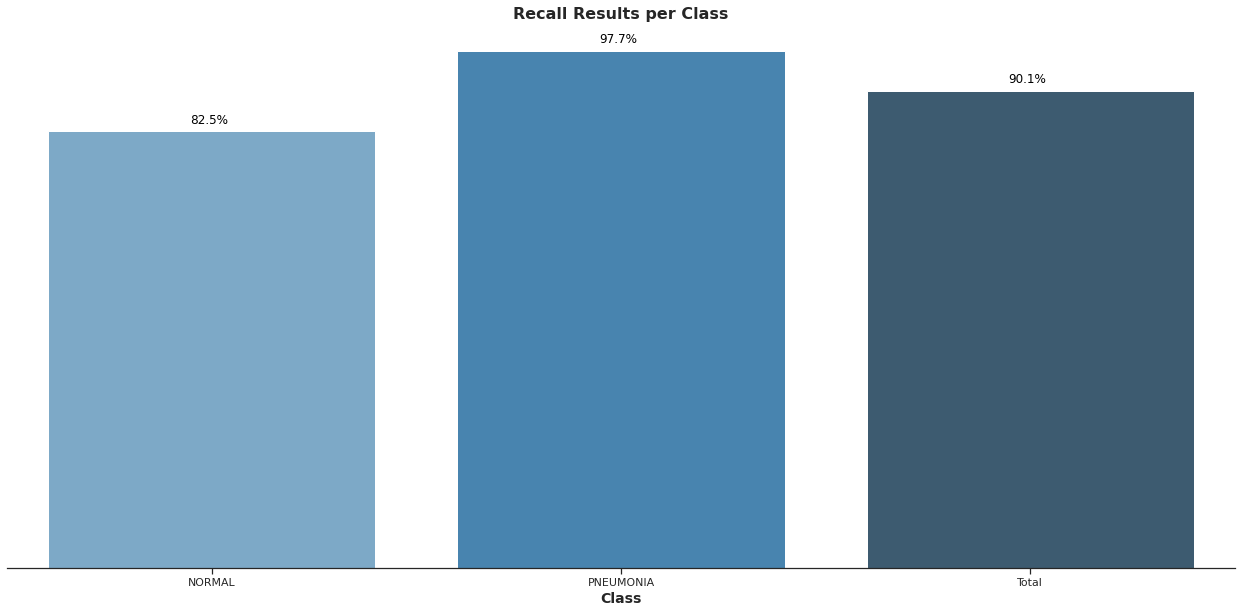

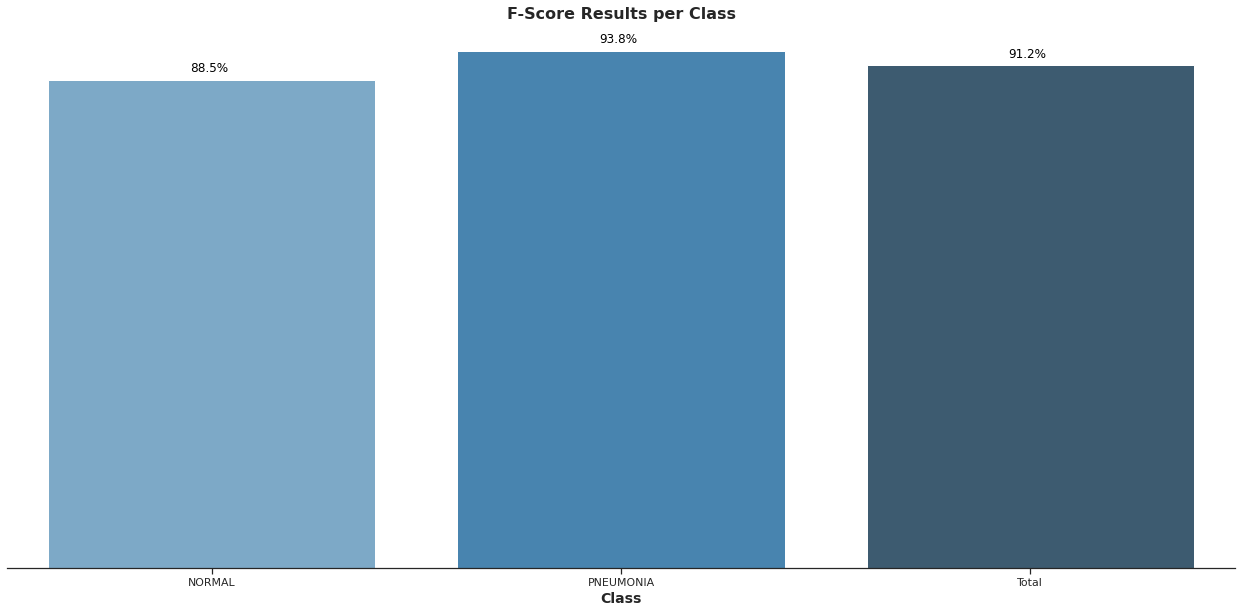

In [125]:
#Accuracy Result
acc = accuracy_score(test_set.labels, y_pred_prob_InceptionV3)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(test_set.labels, y_pred_prob_InceptionV3, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(test_set.labels, y_pred_prob_InceptionV3, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['NORMAL', 'PNEUMONIA', 'Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))#F-Score of the whole Dataset

In [126]:
# model_densenet
# model_efnet
# model_vgg

for layer in model_VGG16.layers:
  layer.trainable = False

for layer in model_Xception.layers:
  layer.trainable = False

for layer in model_ResNet152V2.layers:
  layer.trainable = False

for layer in model_InceptionV3.layers:
  layer.trainable = False

#for layer in model_EfficientNetB7.layers:
#  layer.trainable = False    

#for layer in model_NasNet.layers:
#  layer.trainable = False

visible = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), name="input")
x = model_VGG16(visible)
x = model_Xception(visible)
x = model_ResNet152V2(visible)
x = model_InceptionV3(visible)
#x = model_EfficientNetB7(visible)
merge = tf.keras.layers.concatenate([x, x, x, x], name= "concatallprobs")
model_out = tf.keras.layers.Dense(1, activation='sigmoid', name="predictions")(merge)

model_VGG16_Xception_ResNet152V2_InceptionV3 = Model(inputs=visible, outputs=model_out)
model_VGG16_Xception_ResNet152V2_InceptionV3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
model_VGG16_Xception_ResNet152V2_InceptionV3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 1)            22327585    input[0][0]                      
__________________________________________________________________________________________________
concatallprobs (Concatenate)    (None, 4)            0           model[0][0]                      
                                                                 model[0][0]                      
                                                                 model[0][0]                      
                                                                 model[0][0]                

In [127]:
#Model Parameters
#epochs = 2 # make it 1000

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1) #check val_loss

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-5 ,verbose=1) #min_lr as input for fine tuning next

In [128]:
history = model_VGG16_Xception_ResNet152V2_InceptionV3.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)
#y_pred = model_MobileNet_DenseNet_EfNet.predict(test_set)
y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3 = model_VGG16_Xception_ResNet152V2_InceptionV3.predict(test_set)
y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3 = y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3 > 0.5
fpr_VGG16_Xception_ResNet152V2_InceptionV3, tpr_VGG16_Xception_ResNet152V2_InceptionV3, thresholds_VGG16_Xception_ResNet152V2_InceptionV3 = roc_curve(test_set.labels, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3)
roc_auc_VGG16_Xception_ResNet152V2_InceptionV3 = auc(fpr_VGG16_Xception_ResNet152V2_InceptionV3, tpr_VGG16_Xception_ResNet152V2_InceptionV3)
precision_VGG16_Xception_ResNet152V2_InceptionV3, recall_VGG16_Xception_ResNet152V2_InceptionV3, th_VGG16_Xception_ResNet152V2_InceptionV3 = precision_recall_curve(test_set.labels, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3)


Epoch 1/50
138/138 [==============================] - 98s 681ms/step - loss: 0.5644 - accuracy: 0.7601 - val_loss: 0.4612 - val_accuracy: 0.8125
Epoch 2/50
138/138 [==============================] - 92s 667ms/step - loss: 0.5590 - accuracy: 0.7993 - val_loss: 0.4516 - val_accuracy: 0.8724
Epoch 3/50
138/138 [==============================] - 92s 666ms/step - loss: 0.5543 - accuracy: 0.8183 - val_loss: 0.4424 - val_accuracy: 0.8893
Epoch 4/50
138/138 [==============================] - 93s 672ms/step - loss: 0.5476 - accuracy: 0.8369 - val_loss: 0.4344 - val_accuracy: 0.9023
Epoch 5/50
138/138 [==============================] - 92s 668ms/step - loss: 0.5413 - accuracy: 0.8458 - val_loss: 0.4290 - val_accuracy: 0.9049
Epoch 6/50
138/138 [==============================] - 92s 663ms/step - loss: 0.5343 - accuracy: 0.8598 - val_loss: 0.4205 - val_accuracy: 0.9154
Epoch 7/50
138/138 [==============================] - 92s 669ms/step - loss: 0.5301 - accuracy: 0.8636 - val_loss: 0.4126 - val_ac

In [129]:
model_VGG16_Xception_ResNet152V2_InceptionV3.save("model_VGG16_Xception_ResNet152V2_InceptionV3.h5")

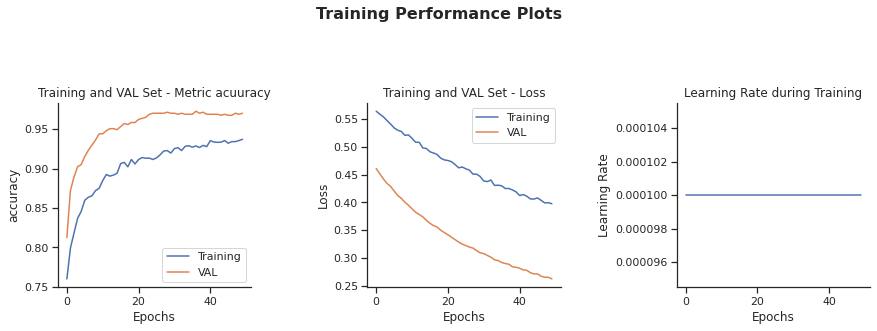

In [130]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(13,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="VAL");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="VAL");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and VAL Set - Metric acuuracy")
axarr[1].set_title("Training and VAL Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [131]:
loss, acc = model_VGG16_Xception_ResNet152V2_InceptionV3.evaluate(test_set)

20/20 [==============================] - 6s 266ms/step - loss: 0.3925 - accuracy: 0.8702


In [132]:
#Predicted labels
prediction_VGG16_Xception_ResNet152V2_InceptionV3 = model_VGG16_Xception_ResNet152V2_InceptionV3.predict(test_set)
prediction_VGG16_Xception_ResNet152V2_InceptionV3 = prediction_VGG16_Xception_ResNet152V2_InceptionV3 > 0.5

#True labels
orig_VGG16_Xception_ResNet152V2_InceptionV3 = test_set.labels

In [133]:
cm_VGG16_Xception_ResNet152V2_InceptionV3 = confusion_matrix(orig_VGG16_Xception_ResNet152V2_InceptionV3, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3)
print('Confusion matrix:')
print(cm_VGG16_Xception_ResNet152V2_InceptionV3)
print('')

cr_VGG16_Xception_ResNet152V2_InceptionV3 = classification_report(orig_VGG16_Xception_ResNet152V2_InceptionV3, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3)
print('Classification report:')
print(cr_VGG16_Xception_ResNet152V2_InceptionV3)
print('')

Confusion matrix:
[[157  77]
 [  4 386]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       234
           1       0.83      0.99      0.91       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.89      0.87      0.86       624




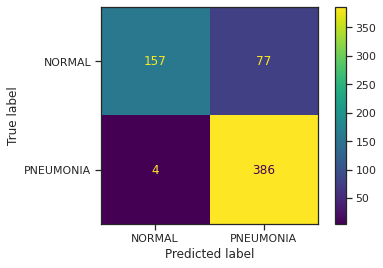

In [134]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_VGG16_Xception_ResNet152V2_InceptionV3,display_labels=['NORMAL','PNEUMONIA'])
disp.plot()

errori commessi:  81


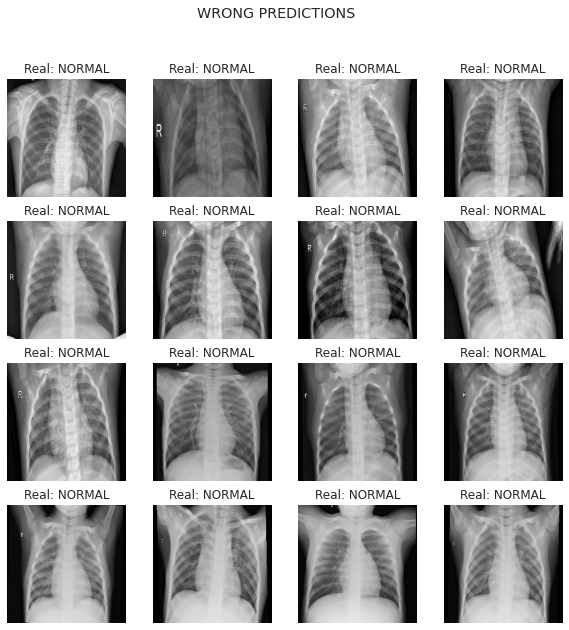

In [135]:
err=[i for i, (x, y) in enumerate(zip(y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3, test_set.labels)) if x != y] #check where orig and predictions don't match (wrong classification)
#print(err)
print('errori commessi: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): #plot max 16 wrong predictions
    bn=err[n]//BATCH_SIZE #number of batch of wrong prediction train_set[bn][0][image]
    ib=err[n]-BATCH_SIZE*bn #number of the image in the batch size train_set[bn][0][ib]
    #print('id_err:',err[n],' batch:',bn,' diff:',err[n]-BATCH_SIZE*bn)
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8))  #uint8 to plot
    
    if test_set[bn][1][ib]: #real value
        plt.title("Real: PNEUMONIA")
    else:
        plt.title("Real: NORMAL")
    plt.axis("off")

**Overall Results**
Accuracy Result: 87.02%
Precision Result: 90.44%
Recall Result: 83.03%
F-Score Result: 85.00%


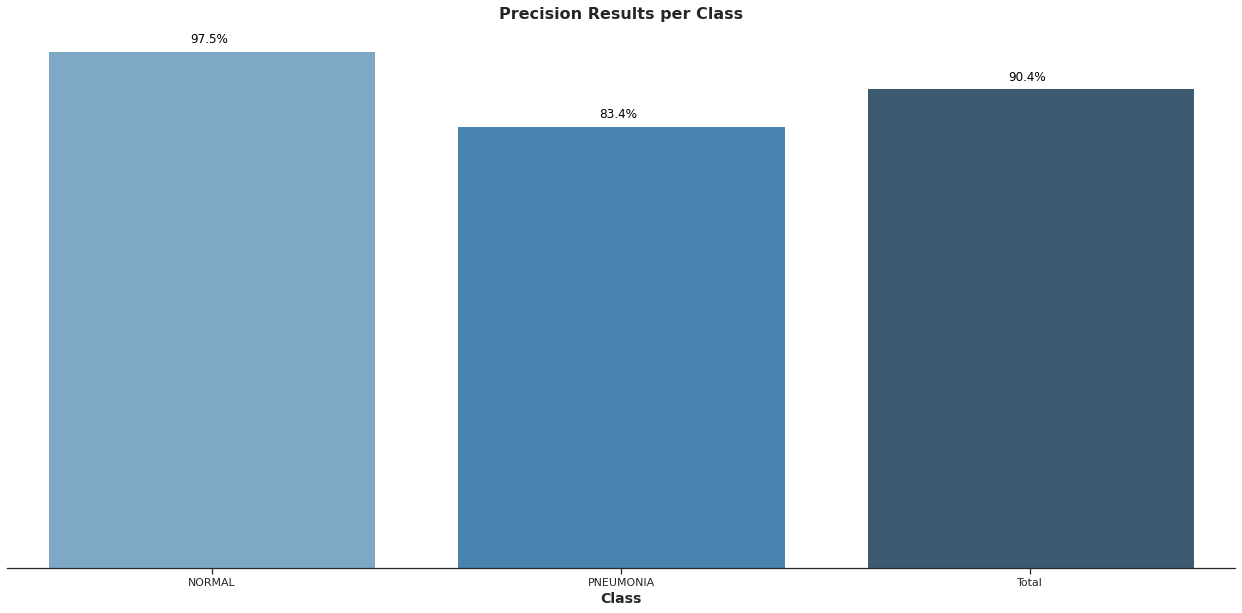

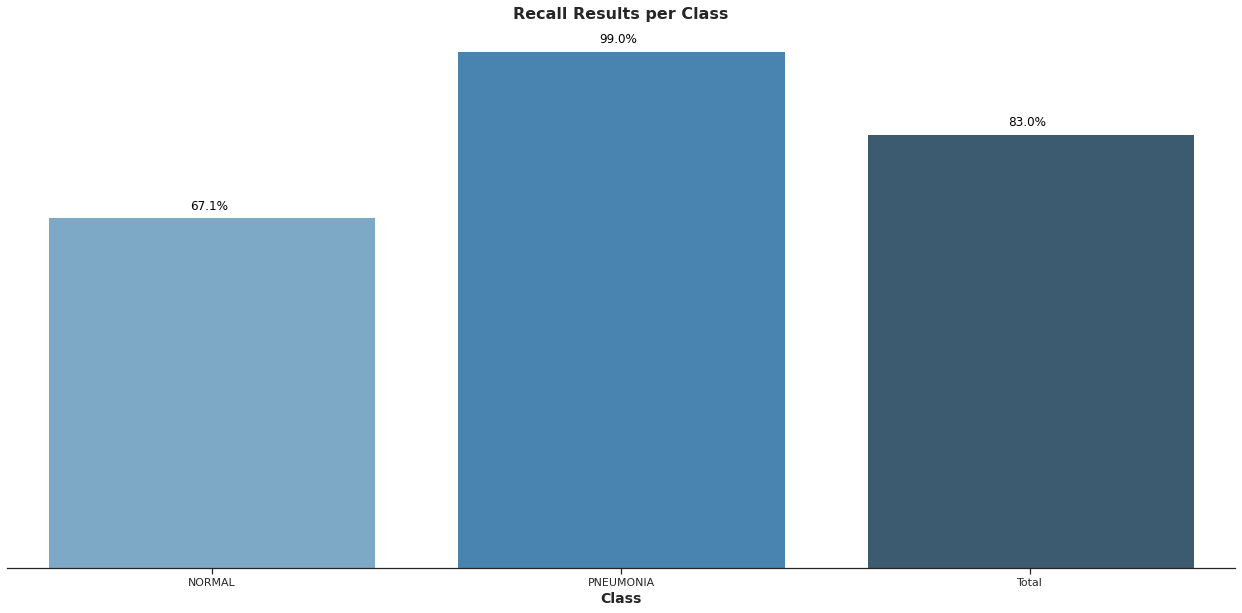

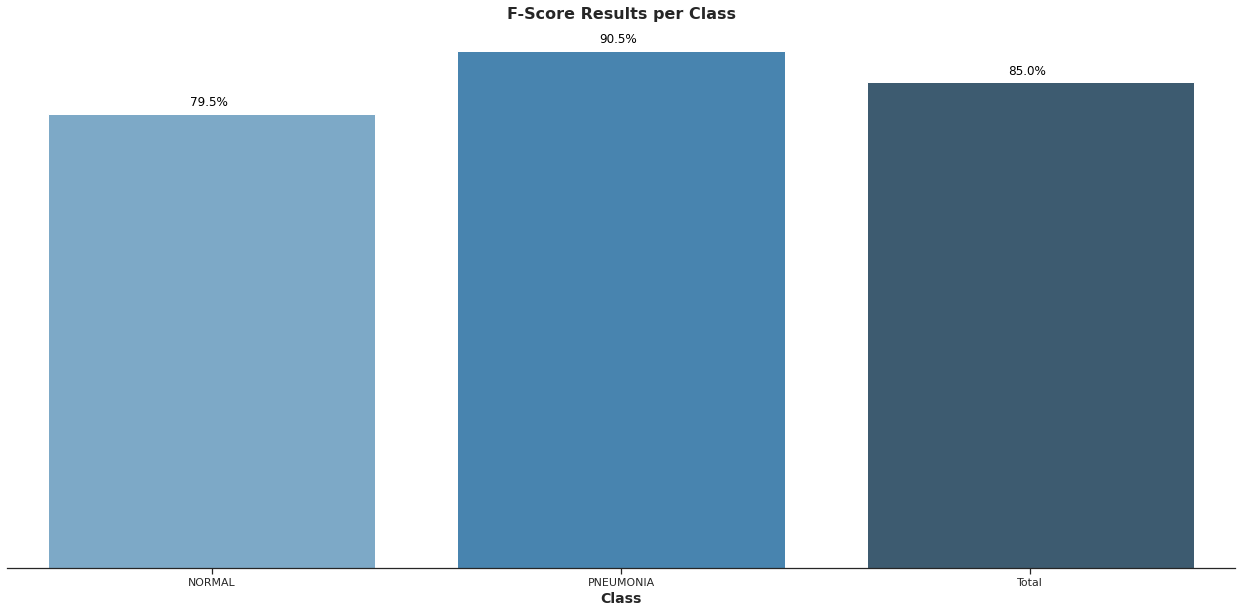

In [136]:
#Accuracy Result
acc = accuracy_score(test_set.labels, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(test_set.labels, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(test_set.labels, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['NORMAL', 'PNEUMONIA', 'Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))#F-Score of the whole Dataset

In [137]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

In [138]:
train_set.class_indices
vali_set.class_indices
test_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [139]:
import numpy as np

def normalize(array2d: np.ndarray) -> np.ndarray:
    return array2d / array2d.sum(axis=1, keepdims=True)

class_names = ["PNEUMONIA", "NORMAL"]
num_classes = len(class_names)
num_samples = 500

# Mock ground truth
ground_truth = np.random.choice(range(num_classes), size=num_samples, p=[0.5, 0.5])

# Mock model predictions
perfect_model = np.eye(num_classes)[ground_truth]
noisy_model = normalize(
    perfect_model + 2 * np.random.random((num_samples, num_classes))
)
random_model = normalize(np.random.random((num_samples, num_classes)))

In [140]:
!pip install metriculous

     |████████████████████████████████| 50 kB 742 kB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for assertpy: filename=assertpy-1.1-py3-none-any.whl size=42918 sha256=8cc64c586ff62fb4ce0a43dfc95d44763e9d2a81358169c7f8f9d34628c16247
  Stored in directory: /root/.cache/pip/wheels/8f/92/6f/9155307fe482780bc335f3a8eaf8592ccb4073f1efad1e3cb2
Successfully built assertpy


In [141]:
import metriculous

metriculous.compare_classifiers(
    ground_truth=ground_truth,
    model_predictions=[perfect_model, noisy_model, random_model],
    model_names=["Perfect Model", "Noisy Model", "Random Model"],
    class_names=class_names,
    one_vs_all_figures=True, # This line is important to include ROC curves in the output
).save_html("model_comparison.html").display()

Loading BokehJS ...

sh: 1: afplay: not found


In [142]:
!pip install plot_metric

In [143]:
!pip install ggplot

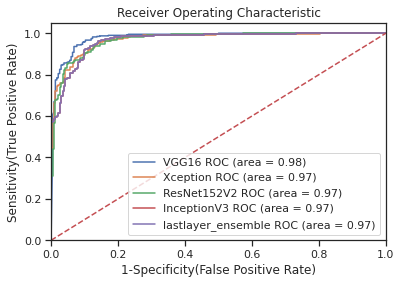

In [144]:
from tensorflow.keras.models import load_model
def VGG16():
      return (load_model('model_VGG16.h5'))  #model_DenseNet_30_09596.h5   #model_EfNet_30_09596.h5    /content/model_VGG16.h5
def Xception():
      return(load_model('model_Xception.h5'))    #model_MobileNet_30_09596.h5  /content/model_Xception.h5
def ResNet152V2():
      return(load_model('model_ResNet152V2.h5')) #./model_VGG16_Xception_ResNet152V2_InceptionV3.h5
def InceptionV3():
      return(load_model('model_InceptionV3.h5')) 
def lastlayer_en():
      return(load_model('model_VGG16_Xception_ResNet152V2_InceptionV3.h5'))

models = [
    {
        'label': 'VGG16',
        'model': VGG16(),
    },
    {
        'label': 'Xception',
        'model':Xception(),
    },
    {
        'label': 'ResNet152V2',
        'model':ResNet152V2(),
    },
    {
        'label': 'InceptionV3',
        'model':InceptionV3(),
    },
    {
        'label': 'lastlayer_ensemble',
        'model':lastlayer_en(),
    }]
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
plt.figure()
    
    # Below for loop iterates through your models list
for m in models:
        model = m['model'] # select the model
        #model.fit(X_train, y_train) # train the model
        y_pred=model.predict(test_set) # predict the test data
    # Compute False postive rate, and True positive rate
        #fpr, tpr, thresholds = metrics.roc_curve(y_test, model.y_pred_bin(X_test)[:,1])    model.predict_on_batch(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(test_set.labels, model.predict(test_set))
    # Calculate Area under the curve to display on the plot
        auc = metrics.roc_auc_score(test_set.labels,model.predict(test_set))
    # Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
    # Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

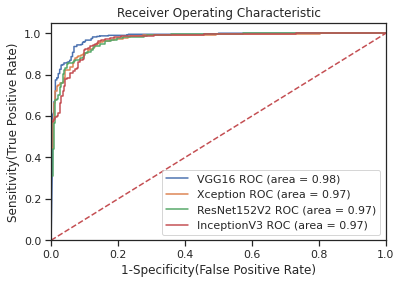

In [145]:
from tensorflow.keras.models import load_model
def VGG16():
      return (load_model('model_VGG16.h5'))  #model_DenseNet_30_09596.h5   #model_EfNet_30_09596.h5    /content/model_VGG16.h5
def Xception():
      return(load_model('model_Xception.h5'))    #model_MobileNet_30_09596.h5  /content/model_Xception.h5
def ResNet152V2():
      return(load_model('model_ResNet152V2.h5'))   #/content/model_ResNet152V2.h5
def InceptionV3():
      return(load_model('model_InceptionV3.h5')) 
#def ():
#      return(load_model('model_VGG16_Xception_ResNet152V2.h5'))

models = [
    {
        'label': 'VGG16',
        'model': VGG16(),
    },
    {
        'label': 'Xception',
        'model':Xception(),
    },
    {
        'label': 'ResNet152V2',
        'model':ResNet152V2(),
    },
    {
        'label': 'InceptionV3',
        'model':InceptionV3(),
    }]
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
plt.figure()
    
    # Below for loop iterates through your models list
for m in models:
        model = m['model'] # select the model
        #model.fit(X_train, y_train) # train the model
        y_pred=model.predict(test_set) # predict the test data
    # Compute False postive rate, and True positive rate
        #fpr, tpr, thresholds = metrics.roc_curve(y_test, model.y_pred_bin(X_test)[:,1])    model.predict_on_batch(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(test_set.labels, model.predict(test_set))
    # Calculate Area under the curve to display on the plot
        auc = metrics.roc_auc_score(test_set.labels,model.predict(test_set))
    # Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
    # Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

In [146]:
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, 
                             classification_report, f1_score, average_precision_score, precision_recall_fscore_support)

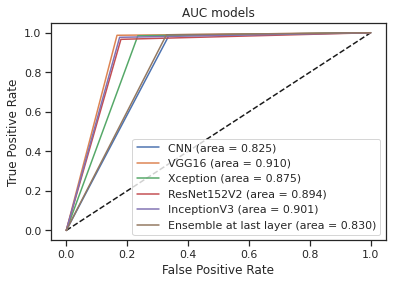

In [147]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='CNN (area = %0.3f)' % roc_auc_lr)
plt.plot(fpr_VGG16, tpr_VGG16, label='VGG16 (area = %0.3f)' % roc_auc_VGG16)
plt.plot(fpr_Xception, tpr_Xception, label='Xception (area = %0.3f)' % roc_auc_Xception)
plt.plot(fpr_ResNet152V2, tpr_ResNet152V2, label='ResNet152V2 (area = %0.3f)' % roc_auc_ResNet152V2)
plt.plot(fpr_InceptionV3, tpr_InceptionV3, label='InceptionV3 (area = %0.3f)' % roc_auc_InceptionV3)
plt.plot(fpr_VGG16_Xception_ResNet152V2_InceptionV3, tpr_VGG16_Xception_ResNet152V2_InceptionV3, label='Ensemble at last layer (area = %0.3f)' % roc_auc_VGG16_Xception_ResNet152V2_InceptionV3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC models')
plt.legend(loc='best')
plt.show()

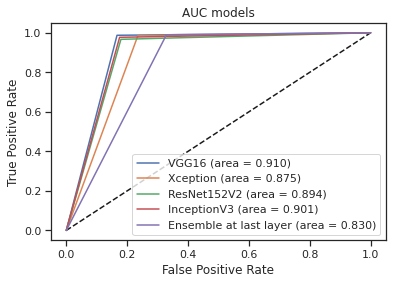

In [148]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_lr, tpr_lr, label='CNN (area = %0.3f)' % roc_auc_lr)
plt.plot(fpr_VGG16, tpr_VGG16, label='VGG16 (area = %0.3f)' % roc_auc_VGG16)
plt.plot(fpr_Xception, tpr_Xception, label='Xception (area = %0.3f)' % roc_auc_Xception)
plt.plot(fpr_ResNet152V2, tpr_ResNet152V2, label='ResNet152V2 (area = %0.3f)' % roc_auc_ResNet152V2)
plt.plot(fpr_InceptionV3, tpr_InceptionV3, label='InceptionV3 (area = %0.3f)' % roc_auc_InceptionV3)
plt.plot(fpr_VGG16_Xception_ResNet152V2_InceptionV3, tpr_VGG16_Xception_ResNet152V2_InceptionV3, label='Ensemble at last layer (area = %0.3f)' % roc_auc_VGG16_Xception_ResNet152V2_InceptionV3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC models')
plt.legend(loc='best')
plt.show()

In [149]:
# model2= Model(inputs=model1.input, outputs=model1.get_layer(layer_name).output)

model_VGG16_nohead = Model(inputs=model_VGG16.input, outputs=model_VGG16.get_layer("dense_head_vgg").output)
model_Xception_nohead = Model(inputs=model_Xception.input, outputs=model_Xception.get_layer("dense_head_xception").output)
model_ResNet152V2_nohead = Model(inputs=model_ResNet152V2.input, outputs=model_ResNet152V2.get_layer("dense_head_resnet_v2").output)
model_InceptionV3_nohead = Model(inputs=model_InceptionV3.input, outputs=model_InceptionV3.get_layer("dense_head_InceptionV3").output)

for layer in model_VGG16_nohead.layers:
  layer.trainable = False

for layer in model_Xception_nohead.layers:
  layer.trainable = False

for layer in model_ResNet152V2_nohead.layers:
  layer.trainable = False

for layer in model_InceptionV3_nohead.layers:
  layer.trainable = False

visible = tf.keras.layers.Input(shape=(224, 224, 3), name="input")
x = model_VGG16_nohead(visible)
x = model_Xception_nohead(visible)
x = model_ResNet152V2_nohead(visible)
x = model_InceptionV3_nohead(visible)

merge = tf.keras.layers.concatenate([x, x, x, x], name="concatallprobs")
model_out = tf.keras.layers.Dense(1, activation='sigmoid', name="predictions")(merge)

model_VGG16_Xception_ResNet152V2_InceptionV3_nohead = Model(inputs=visible, outputs=model_out)
model_VGG16_Xception_ResNet152V2_InceptionV3_nohead.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy']) #categorical_smooth_loss
model_VGG16_Xception_ResNet152V2_InceptionV3_nohead.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_5 (Functional)            (None, 256)          22327328    input[0][0]                      
__________________________________________________________________________________________________
concatallprobs (Concatenate)    (None, 1024)         0           model_5[0][0]                    
                                                                 model_5[0][0]                    
                                                                 model_5[0][0]                    
                                                                 model_5[0][0]              

In [150]:
#Model Parameters
#epochs = 2 # make it 1000

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1) #check val_loss

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-5 ,verbose=1) #min_lr as input for fine tuning next

In [151]:
history = model_VGG16_Xception_ResNet152V2_InceptionV3_nohead.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)
#y_pred = model_MobileNet_DenseNet_EfNet.predict(test_set)
y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3_nohead = model_VGG16_Xception_ResNet152V2_InceptionV3_nohead.predict(test_set)
y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3_nohead = y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3_nohead > 0.5
fpr_VGG16_Xception_ResNet152V2_InceptionV3_nohead, tpr_VGG16_Xception_ResNet152V2_InceptionV3_nohead, thresholds_VGG16_Xception_ResNet152V2_InceptionV3_nohead = roc_curve(test_set.labels, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3_nohead)
roc_auc_VGG16_Xception_ResNet152V2_InceptionV3_nohead = auc(fpr_VGG16_Xception_ResNet152V2_InceptionV3_nohead, tpr_VGG16_Xception_ResNet152V2_InceptionV3_nohead)
precision_VGG16_Xception_ResNet152V2_InceptionV3_nohead, recall_VGG16_Xception_ResNet152V2_InceptionV3_nohead, th_VGG16_Xception_ResNet152V2_InceptionV3_nohead = precision_recall_curve(test_set.labels, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3_nohead)

Epoch 1/50
138/138 [==============================] - 98s 689ms/step - loss: 0.1838 - accuracy: 0.9379 - val_loss: 0.1776 - val_accuracy: 0.9401
Epoch 2/50
138/138 [==============================] - 93s 675ms/step - loss: 0.1425 - accuracy: 0.9484 - val_loss: 0.1827 - val_accuracy: 0.9336
Epoch 3/50
138/138 [==============================] - 93s 676ms/step - loss: 0.1491 - accuracy: 0.9475 - val_loss: 0.1888 - val_accuracy: 0.9375
Epoch 4/50
138/138 [==============================] - 94s 680ms/step - loss: 0.1485 - accuracy: 0.9450 - val_loss: 0.1544 - val_accuracy: 0.9401
Epoch 5/50
138/138 [==============================] - 94s 685ms/step - loss: 0.1404 - accuracy: 0.9504 - val_loss: 0.1469 - val_accuracy: 0.9427
Epoch 6/50
138/138 [==============================] - 93s 678ms/step - loss: 0.1420 - accuracy: 0.9479 - val_loss: 0.1416 - val_accuracy: 0.9453
Epoch 7/50
138/138 [==============================] - 94s 681ms/step - loss: 0.1402 - accuracy: 0.9518 - val_loss: 0.1945 - val_ac

In [152]:
model_VGG16_Xception_ResNet152V2_InceptionV3_nohead.save("model_VGG16_Xception_ResNet152V2_InceptionV3_nohead.h5")

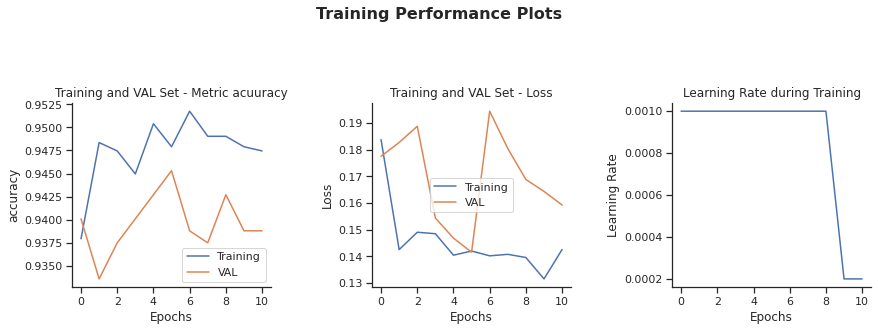

In [153]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(13,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_accuracy'],ax=axarr[0],label="VAL");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="VAL");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and VAL Set - Metric acuuracy")
axarr[1].set_title("Training and VAL Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [154]:
loss, acc = model_VGG16_Xception_ResNet152V2_InceptionV3_nohead.evaluate(test_set)

20/20 [==============================] - 6s 259ms/step - loss: 0.2659 - accuracy: 0.9151


In [155]:
#Predicted labels
prediction_VGG16_Xception_ResNet152V2_InceptionV3_nohead = model_VGG16_Xception_ResNet152V2_InceptionV3_nohead.predict(test_set)
prediction_VGG16_Xception_ResNet152V2_InceptionV3_nohead = prediction_VGG16_Xception_ResNet152V2_InceptionV3_nohead > 0.5

#True labels   VGG16_Xception_ResNet152V2_InceptionV3_nohead
orig_VGG16_Xception_ResNet152V2_InceptionV3_nohead = test_set.labels

In [156]:
cm_VGG16_Xception_ResNet152V2_InceptionV3_nohead = confusion_matrix(orig_VGG16_Xception_ResNet152V2_InceptionV3_nohead, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3_nohead)
print('Confusion matrix:')
print(cm_VGG16_Xception_ResNet152V2_InceptionV3_nohead)
print('')

cr_VGG16_Xception_ResNet152V2_InceptionV3_nohead = classification_report(orig_VGG16_Xception_ResNet152V2_InceptionV3_nohead, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3_nohead)
print('Classification report:')
print(cr_VGG16_Xception_ResNet152V2_InceptionV3_nohead)
print('')

Confusion matrix:
[[194  40]
 [ 13 377]]

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       234
           1       0.90      0.97      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.91       624




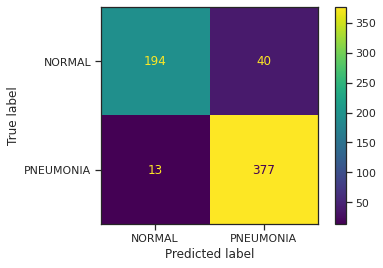

In [157]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_VGG16_Xception_ResNet152V2_InceptionV3_nohead,display_labels=['NORMAL','PNEUMONIA'])
disp.plot()

errori commessi:  53


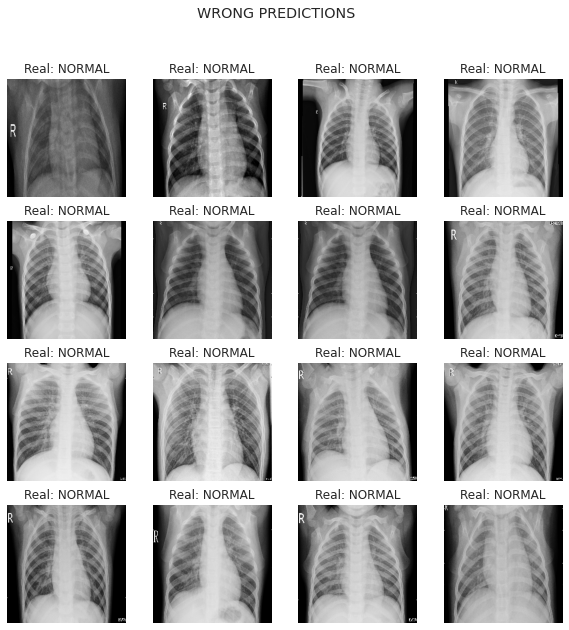

In [158]:
err=[i for i, (x, y) in enumerate(zip(y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3_nohead, test_set.labels)) if x != y] #check where orig and predictions don't match (wrong classification)
#print(err)
print('errori commessi: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): #plot max 16 wrong predictions
    bn=err[n]//BATCH_SIZE #number of batch of wrong prediction train_set[bn][0][image]
    ib=err[n]-BATCH_SIZE*bn #number of the image in the batch size train_set[bn][0][ib]
    #print('id_err:',err[n],' batch:',bn,' diff:',err[n]-BATCH_SIZE*bn)
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8))  #uint8 to plot
    
    if test_set[bn][1][ib]: #real value
        plt.title("Real: PNEUMONIA")
    else:
        plt.title("Real: NORMAL")
    plt.axis("off")

**Overall Results**
Accuracy Result: 91.51%
Precision Result: 92.06%
Recall Result: 89.79%
F-Score Result: 90.71%


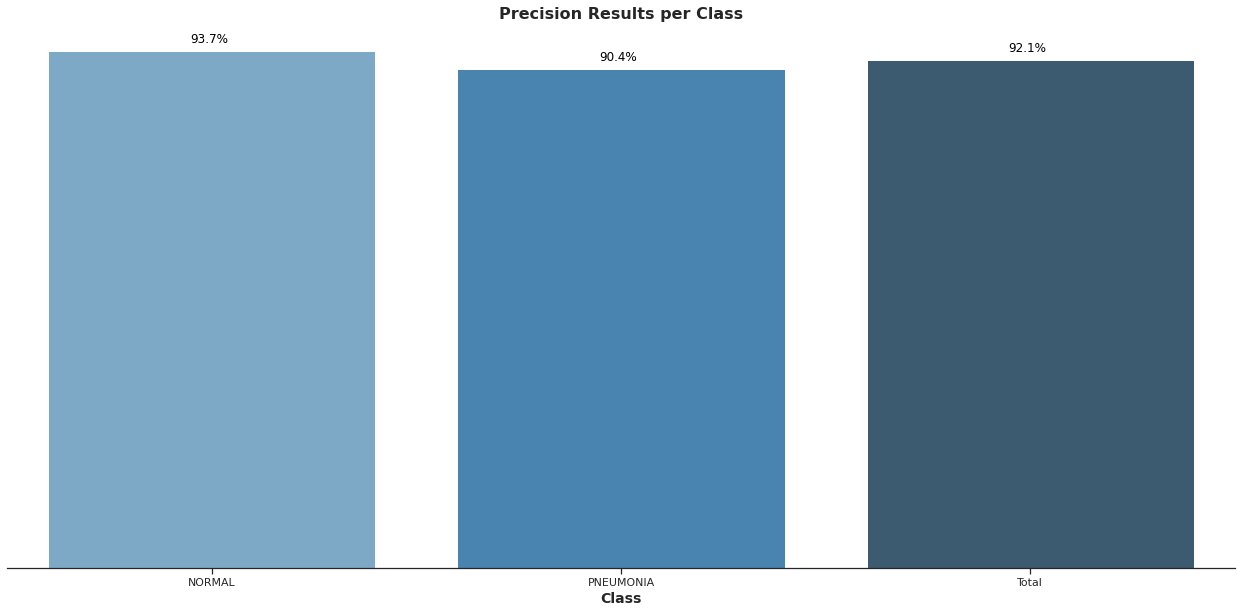

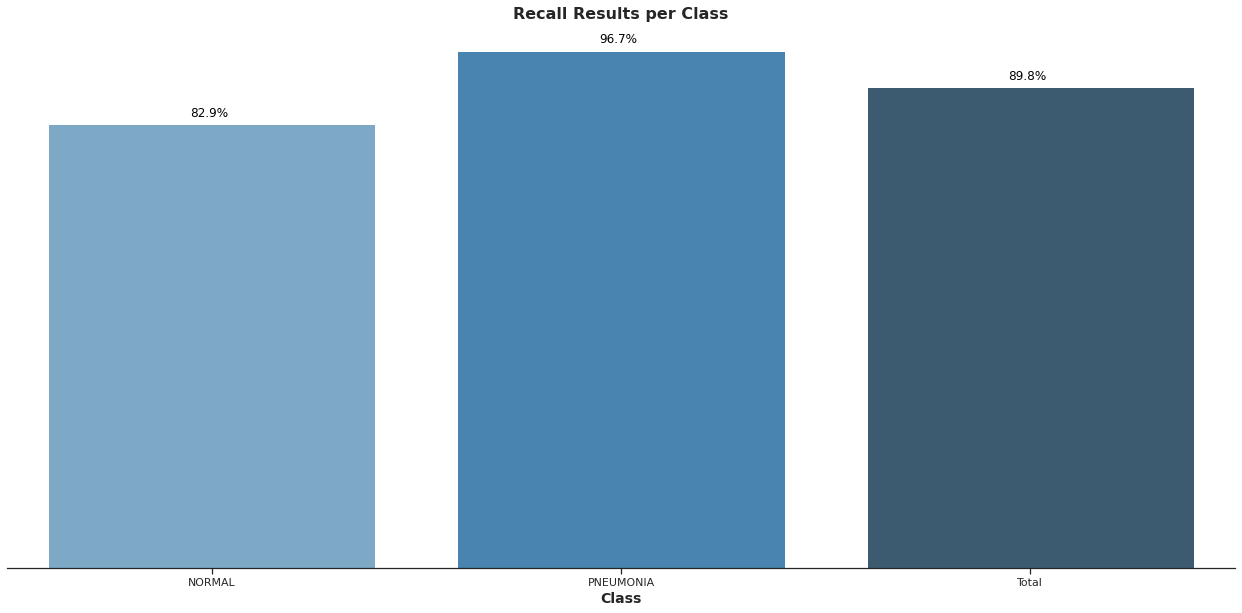

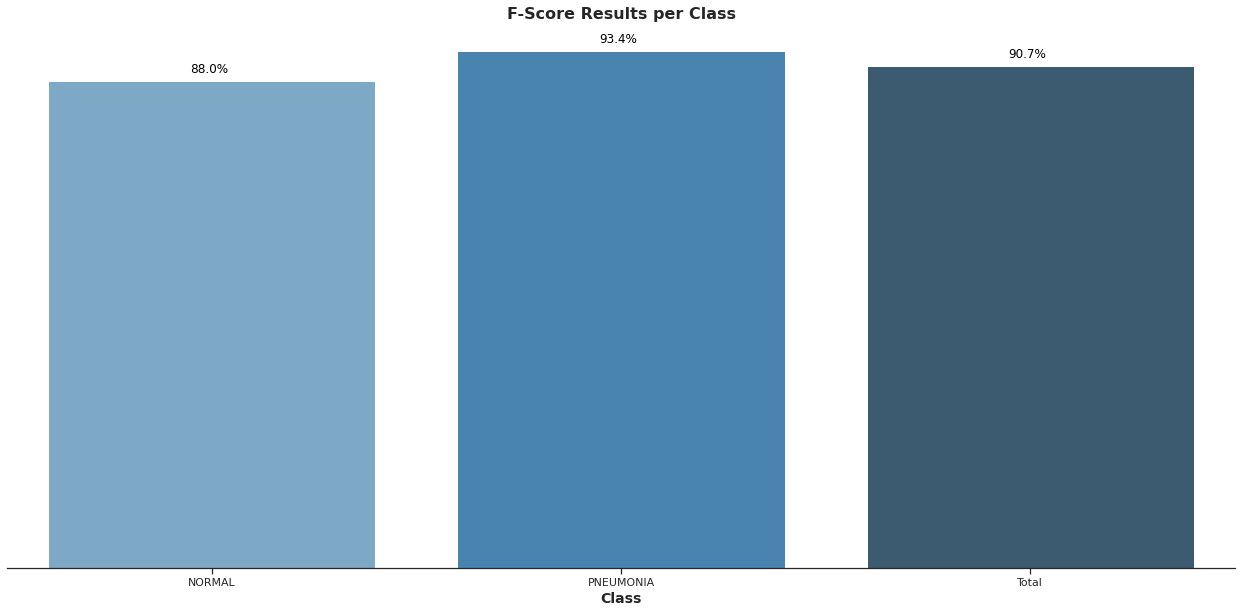

In [159]:
#Accuracy Result
acc = accuracy_score(test_set.labels, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3_nohead)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(test_set.labels, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3_nohead, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(test_set.labels, y_pred_prob_VGG16_Xception_ResNet152V2_InceptionV3_nohead, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['NORMAL', 'PNEUMONIA', 'Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[2,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[2,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[2,2]*100))#F-Score of the whole Dataset

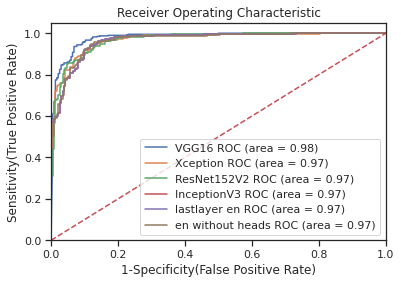

In [160]:
from tensorflow.keras.models import load_model
def VGG16():
      return (load_model('model_VGG16.h5'))  #model_DenseNet_30_09596.h5   #model_EfNet_30_09596.h5    /content/model_VGG16.h5
def Xception():
      return(load_model('model_Xception.h5'))    #model_MobileNet_30_09596.h5  /content/model_Xception.h5
def ResNet152V2():
      return(load_model('model_ResNet152V2.h5')) #./model_VGG16_Xception_ResNet152V2_InceptionV3.h5
def InceptionV3():
      return(load_model('model_InceptionV3.h5')) 
def lastlayer_en():
      return(load_model('model_VGG16_Xception_ResNet152V2_InceptionV3.h5'))

def withoutheads_en():
      return(load_model('model_VGG16_Xception_ResNet152V2_InceptionV3_nohead.h5'))
    #./model_VGG16_Xception_ResNet152V2_InceptionV3_nohead.h5
    
models = [
    {
        'label': 'VGG16',
        'model': VGG16(),
    },
    {
        'label': 'Xception',
        'model':Xception(),
    },
    {
        'label': 'ResNet152V2',
        'model':ResNet152V2(),
    },
    {
        'label': 'InceptionV3',
        'model':InceptionV3(),
    },
    {
        'label': 'lastlayer en',
        'model':lastlayer_en(),
    },
    {
        'label': 'en without heads',
        'model':withoutheads_en(),
     }]
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
plt.figure()
    
    # Below for loop iterates through your models list
for m in models:
        model = m['model'] # select the model
        #model.fit(X_train, y_train) # train the model
        y_pred=model.predict(test_set) # predict the test data
    # Compute False postive rate, and True positive rate
        #fpr, tpr, thresholds = metrics.roc_curve(y_test, model.y_pred_bin(X_test)[:,1])    model.predict_on_batch(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(test_set.labels, model.predict(test_set))
    # Calculate Area under the curve to display on the plot
        auc = metrics.roc_auc_score(test_set.labels,model.predict(test_set))
    # Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
    # Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

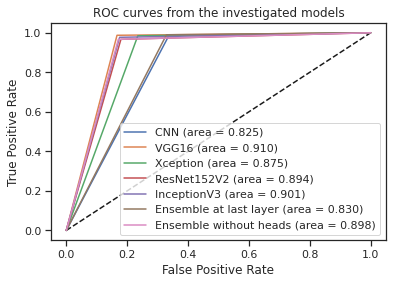

In [161]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='CNN (area = %0.3f)' % roc_auc_lr)
plt.plot(fpr_VGG16, tpr_VGG16, label='VGG16 (area = %0.3f)' % roc_auc_VGG16)
plt.plot(fpr_Xception, tpr_Xception, label='Xception (area = %0.3f)' % roc_auc_Xception)
plt.plot(fpr_ResNet152V2, tpr_ResNet152V2, label='ResNet152V2 (area = %0.3f)' % roc_auc_ResNet152V2)
plt.plot(fpr_InceptionV3, tpr_InceptionV3, label='InceptionV3 (area = %0.3f)' % roc_auc_InceptionV3)
plt.plot(fpr_VGG16_Xception_ResNet152V2_InceptionV3, tpr_VGG16_Xception_ResNet152V2_InceptionV3, label='Ensemble at last layer (area = %0.3f)' % roc_auc_VGG16_Xception_ResNet152V2_InceptionV3)
plt.plot(fpr_VGG16_Xception_ResNet152V2_InceptionV3_nohead, tpr_VGG16_Xception_ResNet152V2_InceptionV3_nohead, label='Ensemble without heads (area = %0.3f)' % roc_auc_VGG16_Xception_ResNet152V2_InceptionV3_nohead)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves from the investigated models')
plt.legend(loc='best')
plt.show()

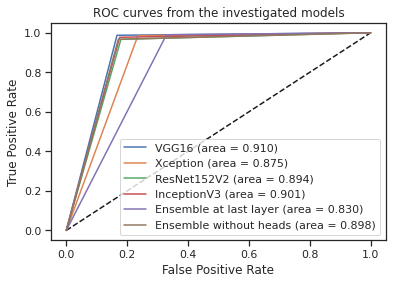

In [163]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_lr, tpr_lr, label='CNN (area = %0.3f)' % roc_auc_lr)
plt.plot(fpr_VGG16, tpr_VGG16, label='VGG16 (area = %0.3f)' % roc_auc_VGG16)
plt.plot(fpr_Xception, tpr_Xception, label='Xception (area = %0.3f)' % roc_auc_Xception)
plt.plot(fpr_ResNet152V2, tpr_ResNet152V2, label='ResNet152V2 (area = %0.3f)' % roc_auc_ResNet152V2)
plt.plot(fpr_InceptionV3, tpr_InceptionV3, label='InceptionV3 (area = %0.3f)' % roc_auc_InceptionV3)
plt.plot(fpr_VGG16_Xception_ResNet152V2_InceptionV3, tpr_VGG16_Xception_ResNet152V2_InceptionV3, label='Ensemble at last layer (area = %0.3f)' % roc_auc_VGG16_Xception_ResNet152V2_InceptionV3)
plt.plot(fpr_VGG16_Xception_ResNet152V2_InceptionV3_nohead, tpr_VGG16_Xception_ResNet152V2_InceptionV3_nohead, label='Ensemble without heads (area = %0.3f)' % roc_auc_VGG16_Xception_ResNet152V2_InceptionV3_nohead)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves from the investigated models')
plt.legend(loc='best')
plt.show()

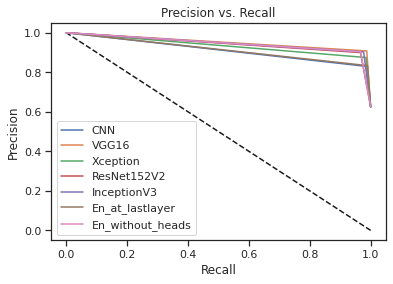

In [164]:
plt.plot([1, 0], [0, 1], 'k--')
plt.plot(recall_lr, precision_lr, label='CNN')
plt.plot(recall_VGG16, precision_VGG16, label='VGG16')
plt.plot(recall_Xception, precision_Xception, label='Xception')
plt.plot(recall_ResNet152V2, precision_ResNet152V2, label='ResNet152V2')
plt.plot(recall_InceptionV3, precision_InceptionV3, label='InceptionV3')
plt.plot(recall_VGG16_Xception_ResNet152V2_InceptionV3, precision_VGG16_Xception_ResNet152V2_InceptionV3, label='En_at_lastlayer')
plt.plot(recall_VGG16_Xception_ResNet152V2_InceptionV3_nohead, precision_VGG16_Xception_ResNet152V2_InceptionV3_nohead, label='En_without_heads')
#plt.plot(recall_en, precision_en, label='Ensamble')
plt.title('Precision vs. Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()